<center><h1><font size="+5">RFM</font></h1></center>



## Préambule

Ce notebook présente une étude RFM (récence, fréquence et montant) pour un site web de commerce électronique brésilien (Olist). L'objectif principal est de segmenter les clients et de comprendre leurs profils.

![RFM](RFM-image.png)

<a id='sec:introduction'></a>
## I. Introduction

### Table des Matières
- [I. Introduction](#sec:introduction)
- [II. Segmentation RFM classique (avec des quantiles)](#sec:segmentation-rfm-classique)
    - [A. Aggrégation, groupement des données et création d'un ensemble de données basé sur les identifiants clients uniques](#subsec:aggregation-groupement-ensemble-donnees-unique)
    - [B. Visualisation de la segmentation RFM classique avec Squarify et analyse des profils clients](#subsec:visualisation-rfm-classique)
- [III. Segmentations RFM utilisant des approches différentes de Machine Learning](#sec:segmentations-approches-differentes)
    - [A. Kmeans](#subsec:kmeans)
    - [B. DBSCAN](#subsec:dbscan)
    - [C. ACH](#subsec:ach)
- [IV. Segmentation RFM + satisfaction client avec une approche de Machine Learning](#sec:segmentation-rfm-satisfaction-client)
- [V. Segmentation RFM + satisfaction client + autres variables avec une approche de Machine Learning + ACP + t-SNE](#sec:segmentation-rfm-satisfaction-client-autres-variables-acp)
- [VI. Conclusion](#sec:conclusion)


Ce notebook présente une étude RFM (récence, fréquence, montant) réalisée sur le site de commerce électronique brésilien Olist. L'objectif principal est de segmenter les clients et de comprendre leurs profils et comportements.

L'analyse RFM évalue la valeur des clients en utilisant trois critères : récence, fréquence et montant. Cette approche permet de définir des segments de clients plus précis et d'adapter les stratégies marketing en conséquence.

Ce notebook suit une approche en plusieurs étapes. Nous commencerons par l'EDA et la préparation des données, puis nous appliquerons la méthode RFM classique avec les variables de récence, fréquence et montant.

Pour améliorer la segmentation, nous explorerons les techniques de Machine Learning. Nous appliquerons une transformation quantile et utiliserons les algorithmes de regroupement K-means, DBSCAN et ACH pour identifier des clusters de clients similaires.

Nous examinerons également l'impact de l'ajout de nouvelles variables, telles que la satisfaction client. Cette approche complète nous permettra de mieux comprendre les profils clients et d'optimiser les décisions marketing.

En conclusion, ce notebook présente une analyse approfondie de la segmentation des clients d'Olist en utilisant la méthode RFM classique et des approches basées sur le Machine Learning. L'objectif est d'optimiser les efforts marketing et d'améliorer la satisfaction et la fidélité des clients.

<a id='sec:segmentation-rfm-classique'></a>
## II. Segmentation RFM classique (avec des quantiles)

In [1]:
# pour editer le jeu de donne
import pandas as pd
import numpy as np
import datetime as dt
import time
from IPython.display import Image
# pour visualiser 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import cufflinks as cf 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import importlib.metadata
from scipy import stats

# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()
%matplotlib inline

In [2]:
#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

In [3]:
!python --version

# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

print("matplotlib - ", importlib.metadata.version('matplotlib'))

Python 3.8.3
pandas - 2.0.3
numpy - 1.23.5
seaborn - 0.12.2
missingno - 0.4.2
cufflinks - 0.17.3
matplotlib -  3.6.2


<a id='subsec:aggregation-groupement-ensemble-donnees-unique'></a>
### A. Aggrégation, groupement des données et création d'un ensemble de données basé sur les identifiants clients uniques


In [4]:
df = pd.read_csv('df_clean.csv')

In [5]:
display(df.head(5))

customer_id primary_payment  common_payment_count  \
0  00012a2ce6f8dcda20d059ce98491703     credit_card                   8.0   
1  000161a058600d5901f007fab4c27140     credit_card                   5.0   
2  0001fd6190edaaf884bcaf3d49edf079     credit_card                  10.0   
3  0002414f95344307404f0ace7a26f1d5          boleto                   1.0   
4  000379cdec625522490c315e70c7a9fb          boleto                   1.0   

   tot_product                          order_id  \
0            1  5f79b5b0931d63f1a42989eb65b9da6e   
1            1  a44895d095d7e0702b6a162fa2dbeced   
2            1  316a104623542e4d75189bb372bc5f8d   
3            1  5825ce2e88d5346438686b0bba99e5ee   
4            1  0ab7fb08086d4af9141453c91878ed7a   

                         product_id  order_item_quantity  \
0  64315bd8c0c47303179dd2e25b579d00                    1   
1  84183944dc7cddca87a5d384452c1d3c                    1   
2  9df2b21ec85378d71df4404712e17478                    1   
3  af3ec22cce878225aae6d9eb6c7a78eb                    1   
4  868b3136c5b206f91b8208fbfdf2cb7c                    1   

  order_purchase_timestamp  order_purchase_date  year month  day  hour  \
0      2017-11-14 16:08:26  2017-11-14 16:00:00  2017   Nov   14    16   
1      2017-07-16 09:40:32  2017-07-16 09:00:00  2017   Jul   16     9   
2      2017-02-28 11:06:43  2017-02-28 11:00:00  2017   Feb   28    11   
3      2017-08-16 13:09:20  2017-08-16 13:00:00  2017   Aug   16    13   
4      2018-04-02 13:42:17  2018-04-02 13:00:00  2018   Apr    2    13   

   days_since_last_order                customer_unique_id  \
0                    287  248ffe10d632bebe4f7267f1f44844c9   
1                    409  b0015e09bb4b6e47c52844fab5fb6638   
2                    547  94b11d37cd61cb2994a194d11f89682b   
3                    378  4893ad4ea28b2c5b3ddf4e82e79db9e6   
4                    149  0b83f73b19c2019e182fd552c048a22c   

   customer_zip_code_prefix customer_city customer_state  payment_sequential  \
0                      6273        osasco             SP                 1.0   
1                     35550   itapecerica             MG                 1.0   
2                     29830  nova venecia             ES                 1.0   
3                     39664      mendonca             MG                 1.0   
4                      4841     sao paulo             SP                 1.0   

  payment_type  payment_installments  payment_value  \
0  credit_card                   8.0         114.74   
1  credit_card                   5.0          67.41   
2  credit_card                  10.0         195.42   
3       boleto                   1.0         179.35   
4       boleto                   1.0         107.01   

                          seller_id   price  freight_value  \
0  7aa4334be125fcdd2ba64b3180029f14   89.80          24.94   
1  2a1348e9addc1af5aaa619b1a3679d6b   54.90          12.51   
2  46dc3b2cc0980fb8ec44634e21d2718e  179.99          15.43   
3  aafe36600ce604f205b86b5084d3d767  149.90          29.45   
4  4a3ca9315b744ce9f8e9374361493884   93.00          14.01   

  product_category_name product_category_name_english main_category_group  \
0            brinquedos                          toys             leisure   
1          beleza_saude                 health_beauty  beauty and hygiene   
2                 bebes                          baby                baby   
3            cool_stuff                    cool_stuff             leisure   
4       cama_mesa_banho                bed_bath_table                home   

   seller_zip_code_prefix        seller_city seller_state  \
0                   18500  laranjal paulista           SP   
1                   30494     belo horizonte           MG   
2                   22240     rio de janeiro           RJ   
3                   88115           sao jose           SC   
4                   14940           ibitinga           SP   

                          review_id  review_score revi

Nous allons maintenant calculer les métriques RFM (Récence, Fréquence, Valeur Monétaire) pour chaque client afin d'obtenir un aperçu de leur comportement d'achat. Ces métriques nous permettront de mieux comprendre la valeur et l'engagement de chaque client.

La métrique Récence mesure le temps écoulé depuis la dernière transaction de chaque client. Nous calculerons la différence entre le jour observé et la date de la dernière commande (date maximale) de chaque client.

La métrique Fréquence est le nombre total de commandes effectuées par chaque client. Nous compterons simplement le nombre d'identifiants de commande pour chaque client.

La métrique Valeur Monétaire représente la somme totale des montants de paiement effectués par chaque client. Nous additionnerons les valeurs de paiement pour chaque client.

In [6]:
display(df.columns)

Index(['customer_id', 'primary_payment', 'common_payment_count', 'tot_product',
       'order_id', 'product_id', 'order_item_quantity',
       'order_purchase_timestamp', 'order_purchase_date', 'year', 'month',
       'day', 'hour', 'days_since_last_order', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'seller_id', 'price', 'freight_value',
       'product_category_name', 'product_category_name_english',
       'main_category_group', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [7]:
df_new = df.groupby("customer_unique_id").agg(
    frequency=("order_id", "nunique"),
    order_purchase_timestamp=("order_purchase_timestamp", "max"),
    recency=("days_since_last_order", "min"),
    customer_state=("customer_state", lambda x: x.mode().iat[0] if len(x.mode()) > 0 else np.nan),
    prefered_payment=("primary_payment", lambda x: x.mode().iat[0] if len(x.mode()) > 0 else np.nan),
    tot_product=("tot_product", "sum"),
    most_frequent_number_of_payments=("common_payment_count", "max"),
    monetary=("payment_value", "sum"),
    review_score=("review_score", "mean"),
    product_category_name=("product_category_name", "nunique")
).reset_index()

**frequency**: représente le nombre unique de commandes effectuées par chaque client.

**order_purchase_timestamp**: indique la date et l'heure de la dernière commande effectuée par chaque client.

**recency**: représente le nombre de jours depuis la dernière commande effectuée par chaque client.

**customer_state**: donne l'état le plus fréquent du client (basé sur l'État du client dans chaque commande).

**prefered_payment**: indique le mode de paiement préféré du client (basé sur le mode de paiement le plus fréquent dans chaque commande).

**tot_product**: représente la somme totale des produits achetés par chaque client.

**most_frequent_number_of_payments**: indique le nombre maximum de paiements effectués pour une commande par chaque client.

**monetary**: représente la somme totale des paiements effectués par chaque client.

**review_score**: donne la note moyenne attribuée par chaque client aux produits achetés.

**product_category_name**: représente le nombre unique de catégories de produits achetées par chaque client.


In [8]:
rfm = df_new[['recency', 'frequency', 'monetary']]

In [9]:
display(rfm.isna().sum())

recency      0
frequency    0
monetary     0
dtype: int64

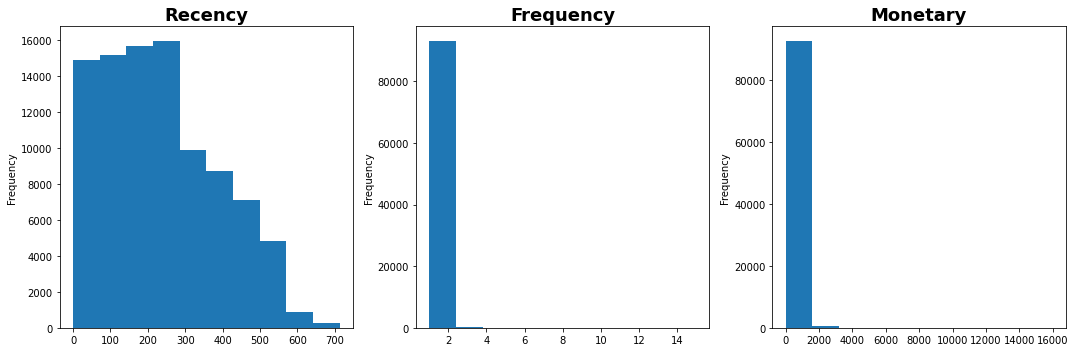

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

rfm["recency"].plot.hist(ax=axes[0])
rfm["frequency"].plot.hist(ax=axes[1])
rfm["monetary"].plot.hist(ax=axes[2])

axes[0].set_title("Recency", fontsize=18, fontweight='bold')
axes[1].set_title("Frequency", fontsize=18, fontweight='bold')
axes[2].set_title("Monetary", fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()

<a id='subsec:visualisation-rfm-classique'></a>
### B. Visualisation de la segmentation RFM classique avec Squarify et analyse des profils clients


Dans cette sous-section, nous explorons la visualisation et l'analyse des segments clients basés sur la méthode RFM classique. Nous commençons par créer le score RFM en évaluant la récence, la fréquence et la valeur monétaire des clients. En utilisant ces scores, nous attribuons un type de client à chaque segment. Nous utilisons également des percentiles pour identifier les valeurs aberrantes et les exclure de l'analyse. Ensuite, nous utilisons Squarify pour représenter graphiquement les segments clients dans un treemap, offrant une vue d'ensemble claire de la répartition des clients dans chaque segment. Nous utilisons également la fonction despine pour améliorer la visualisation en supprimant les bordures inutiles. Cette analyse nous permet de comprendre les caractéristiques et les comportements des différents segments de clients selon la méthode RFM classique.

In [11]:
# Convertir les colonnes en numérique si nécessaire
rfm['recency'] = pd.to_numeric(rfm['recency'])
rfm['frequency'] = pd.to_numeric(rfm['frequency'])
rfm['monetary'] = pd.to_numeric(rfm['monetary'])

# Calculer le score R
rfm['r_score'] = pd.qcut(rfm['recency'], 4, labels=False, duplicates='drop')
# calculé en divisant les données de la colonne 'recency' en 4 intervalles égaux.
rfm['r_score'] = 4 - rfm['r_score'] # ensuite remplacés par des scores de 4 à 1.

# Calculer le score F avec un regroupement ajusté
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, ['1', '2', '3', '4'])
# calculé en attribuant des rangs aux valeurs de la colonne 'frequency' et en divisant ces rangs en 4 intervalles
rfm['f_score'] = pd.to_numeric(rfm['f_score']) #  étiquetés de 1 à 4.

# Calculer le score M
rfm['m_score'] = pd.qcut(rfm['monetary'], 4, labels=False, duplicates='drop')
# calculé en divisant les données de la colonne 'monetary' en 4 intervalles égaux 
rfm['m_score'] += 1 # remplacés par des scores de 1 à 4.

# Calculer le score RFM
rfm['rfm_score'] = 100 * rfm['r_score'] + 10 * rfm['f_score'] + rfm['m_score']
# Le score RFM est obtenu en multipliant le score R par 100, le score F par 10, puis en ajoutant le score M.

# Afficher les 10 premières lignes du DataFrame résultant
display(rfm.head(10))

recency  frequency  monetary  r_score  f_score  m_score  rfm_score
0      111          1    141.90        4        1        3        413
1      114          1     27.19        3        1        1        311
2      536          1     86.22        1        1        2        112
3      320          1     43.62        2        1        1        211
4      287          1    196.89        2        1        4        214
5      145          1    166.98        3        1        3        313
6      131          1     35.38        3        1        1        311
7      182          1    838.36        3        1        4        314
8      542          1    150.12        1        1        3        113
9      169          1    129.76        3        1        3        313

Ce code permet de réaliser la segmentation RFM (Récence, Fréquence, Monétaire) des clients. Chaque score (R, F et M) est calculé en divisant les données correspondantes en intervalles ou en attribuant des rangs. Ensuite, ces scores sont combinés pour obtenir le score RFM final, qui peut être utilisé pour segmenter les clients en groupes selon leur comportement d'achat.

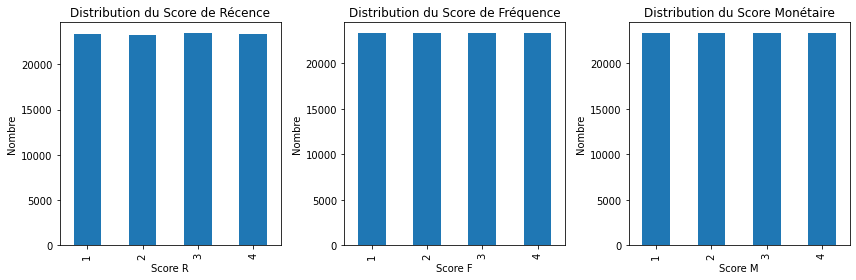

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
rfm['r_score'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Score R')
plt.ylabel('Nombre')
plt.title('Distribution du Score de Récence')

plt.subplot(1, 3, 2)
rfm['f_score'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Score F')
plt.ylabel('Nombre')
plt.title('Distribution du Score de Fréquence')

plt.subplot(1, 3, 3)
rfm['m_score'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Score M')
plt.ylabel('Nombre')
plt.title('Distribution du Score Monétaire')

plt.tight_layout()
plt.show()

In [13]:
def segmentation_client(rfm_score):
    if rfm_score == 444:
        return 'VIP'
    elif 433 <= rfm_score < 444:  # Entre 433 et 444 (exclus), classé "Très fidèle"
        return 'Très fidèle'
    elif 421 <= rfm_score < 433:  # Entre 421 et 433 (exclus), classé "Potentiellement fidèle"
        return 'Potentiellement fidèle'
    elif 344 <= rfm_score < 421:  # Entre 344 et 421 (exclus), classé "Nouveaux clients"
        return 'Nouveaux clients'
    elif 323 <= rfm_score < 344:  # Entre 323 et 344 (exclus), classé "Client potentiel"
        return 'Client potentiel'
    elif 224 <= rfm_score < 311:  # Entre 224 et 311 (exclus), classé "Risque élevé de churn"
        return 'Risque élevé de churn'
    else:
        return 'Clients perdus'

rfm['segmentation_client'] = rfm['rfm_score'].apply(segmentation_client)

display(rfm)

recency  frequency  monetary  r_score  f_score  m_score  rfm_score  \
0          111          1    141.90        4        1        3        413   
1          114          1     27.19        3        1        1        311   
2          536          1     86.22        1        1        2        112   
3          320          1     43.62        2        1        1        211   
4          287          1    196.89        2        1        4        214   
...        ...        ...       ...      ...      ...      ...        ...   
93353      446          1   4134.84        1        4        4        144   
93354      261          1     84.58        2        4        2        242   
93355      567          1    112.46        1        4        3        143   
93356      118          1    133.69        3        4        3        343   
93357      483          1     71.56        1        4        2        142   

         segmentation_client  
0           Nouveaux clients  
1             Clients perdus  
2             Clients perdus  
3             Clients perdus  
4             Clients perdus  
...                      ...  
93353         Clients perdus  
93354  Risque élevé de churn  
93355         Clients perdus  
93356       Client potentiel  
93357         Clients perdus  

[93358 rows x 8 columns]

**__Remarque__** : "**Churn**" est un terme spécifique qui fait référence au phénomène de perte de clients ou d'abandon d'un service ou d'un produit. Dans ce contexte, "__**Risque élevé de churn**__" signifie que ces clients sont plus susceptibles de se désengager ou de cesser d'utiliser les services ou produits offerts.

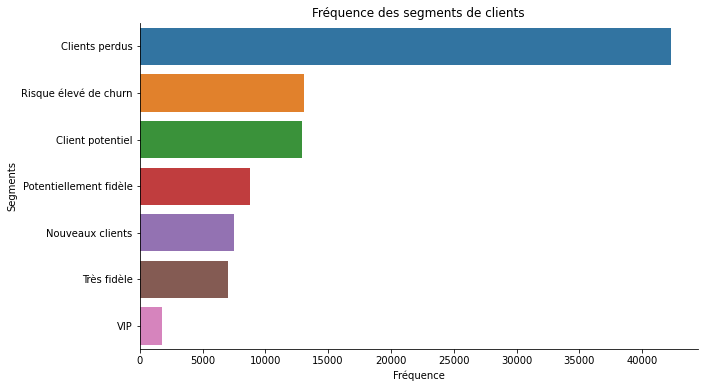

In [14]:
# Calculer les fréquences des segments
segment_counts = rfm['segmentation_client'].value_counts()

# Définir une palette de couleurs personnalisée
colors = sns.color_palette('tab10', n_colors=len(segment_counts))

# Plotter la fréquence de chaque segment
plt.figure(figsize=[10, 6])
sns.barplot(x=segment_counts.values, y=segment_counts.index, palette=colors)
plt.xlabel('Fréquence')
plt.ylabel('Segments')
plt.title('Fréquence des segments de clients')
sns.despine()
plt.show()

In [15]:
# Calcul des limites pour les outliers (5e et 95e percentiles)
print("Limites des valeurs aberrantes (outliers) pour 'Recency' : ", np.percentile(rfm.recency, 5), np.percentile(rfm.recency, 95))
print("Limites des valeurs aberrantes (outliers) pour 'Frequency' : ", np.percentile(rfm.frequency, 5), np.percentile(rfm.frequency, 95))
print("Limites des valeurs aberrantes (outliers) pour 'Monetary' : ", np.percentile(rfm.monetary, 5), np.percentile(rfm.monetary, 95))

Limites des valeurs aberrantes (outliers) pour 'Recency' :  22.0 519.0
Limites des valeurs aberrantes (outliers) pour 'Frequency' :  1.0 1.0
Limites des valeurs aberrantes (outliers) pour 'Monetary' :  32.69 536.3029999999999


Ce code permet de calculer les limites des outliers pour certaines variables sélectionnées, puis de supprimer les lignes correspondant à ces outliers du DataFrame 'rfm'. Cette approche est utilisée pour éliminer les valeurs extrêmes qui pourraient biaiser l'analyse et la visualisation des segments des clients RFM.

In [16]:
# Recherche et suppression des outliers dans les colonnes sélectionnées
outlier_indices = []
columns = [0, 2]  # Indices des colonnes à traiter

# Parcourir les colonnes sélectionnées
for i in columns:
    col = rfm.columns[i]
    # Calcul des limites des outliers (5e et 95e percentiles)
    percentile_5 = np.percentile(rfm[col], 3)
    percentile_95 = np.percentile(rfm[col], 97)
    # Ajout des indices des outliers à la liste outlier_indices
    outlier_indices.extend(rfm[(rfm[col] < percentile_5) | (rfm[col] > percentile_95)].index)

# Suppression des lignes correspondant aux outliers
rfm = rfm.drop(outlier_indices).reset_index(drop=True)

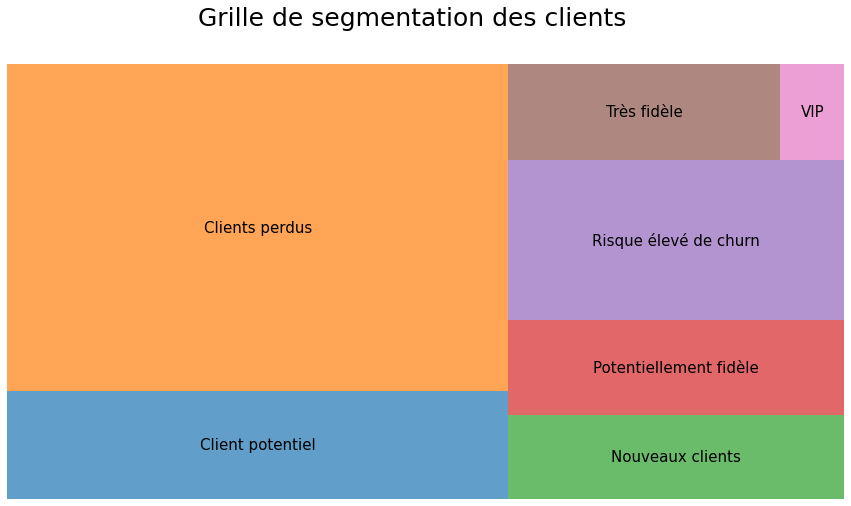

In [17]:
import squarify

plt.figure(figsize=[15, 8])
plt.rc('font', size=15)

# Calculer les tailles des segments
sizes = rfm.groupby('segmentation_client')['monetary'].count()


segment_counts = rfm['segmentation_client'].value_counts()

# Définir une palette de couleurs personnalisée
colors = sns.color_palette('tab10', n_colors=len(segment_counts))

# Tracer le treemap
squarify.plot(sizes=sizes.values, label=sizes.index, color=colors, alpha=.7)

# Ajouter le titre
plt.suptitle("Grille de segmentation des clients", fontsize=25)

plt.axis('off')  # Supprimer les axes
plt.show()

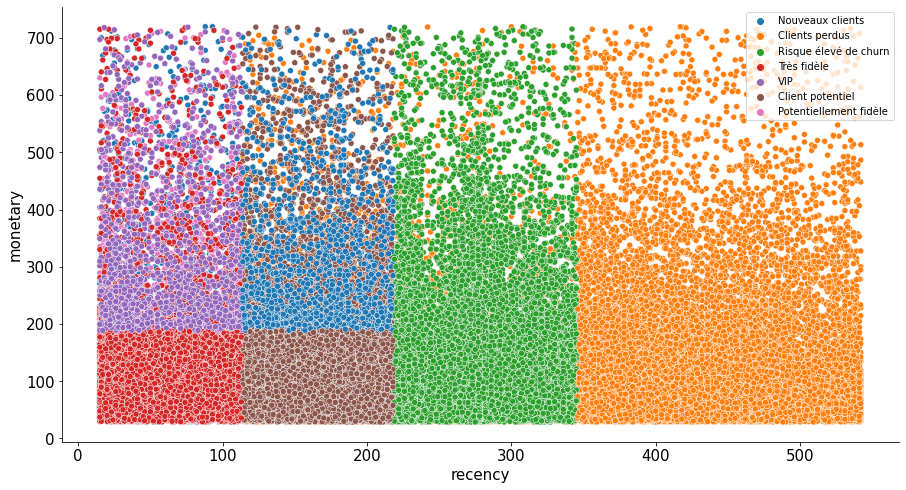

In [18]:
plt.figure(figsize=[15, 8])

# Obtenir le décompte des catégories de segmentation et les trier par index
segment_counts = rfm['segmentation_client'].value_counts().sort_index()

# Définir une palette de couleurs personnalisée en utilisant l'ordre des index des décomptes
colors = sns.color_palette('tab10', n_colors=len(segment_counts))

# Tracer le scatter plot avec des couleurs fixes pour chaque catégorie de segmentation
sns.scatterplot(x=rfm.recency, y=rfm.monetary, hue=rfm.segmentation_client, palette=colors)

# Ajouter la légende et ajuster la taille de police
plt.legend(prop={'size': 10})

# Supprimer les bordures supérieure et droite
sns.despine()

plt.show()

<a id='sec:segmentations-approches-differentes'></a>
## III. Segmentations RFM utilisant des approches différentes de Machine Learning

Après avoir effectué la segmentation RFM classique en utilisant le score RFM, nous passons maintenant à des méthodes de regroupement (cluster) pour classifier les clients à l'aide de techniques avancées de Machine Learning. Ces approches nous permettent d'adopter une approche plus automatisée et sophistiquée pour la segmentation des clients RFM. Nous explorerons différentes techniques, telles que K-means, DBSCAN, ACH, et plus encore, afin d'identifier les segments de clients basés sur les variables RFM. Ces méthodes nous offrent une perspective plus approfondie de la répartition des clients dans des groupes homogènes, ce qui peut être utile pour la personnalisation du marketing, la recommandation de produits et d'autres stratégies de gestion de la relation client.

In [19]:
# Sélection des variables RFM
rfm_log = df_new[['recency', 'frequency', 'monetary']]

# Application du logarithme à recency, frequency et monetary
rfm_log['recency'] = np.log1p(rfm_log['recency'])
rfm_log['frequency'] = np.log1p(rfm_log['frequency'])
rfm_log['monetary'] = np.log1p(rfm_log['monetary'])

# Utilisation de MinMaxScaler pour normaliser les données
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
transformed_rfm = scaler.fit_transform(rfm_log)

# Conversion en DataFrame avec les nouvelles valeurs normalisées
transformed_rfm = pd.DataFrame(transformed_rfm, columns=['recency', 'frequency', 'monetary'])

Cette transformation quantile permet de normaliser les variables RFM et de les rendre comparables entre elles, ce qui facilite l'application de techniques de clustering et d'autres méthodes d'analyse sur les données RFM.

In [20]:
display(transformed_rfm)

recency  frequency  monetary
0      0.718092        0.0  0.512667
1      0.722115        0.0  0.344968
2      0.956644        0.0  0.461659
3      0.878336        0.0  0.392412
4      0.861826        0.0  0.546304
...         ...        ...       ...
93353  0.928727        0.0  0.860356
93354  0.847427        0.0  0.459698
93355  0.965186        0.0  0.488833
93356  0.727318        0.0  0.506554
93357  0.940830        0.0  0.442647

[93358 rows x 3 columns]

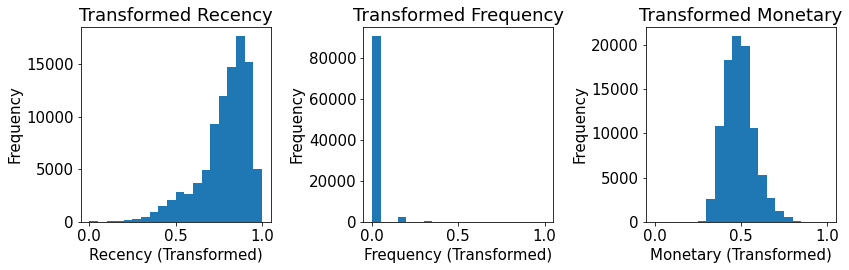

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(transformed_rfm['recency'], bins=20)
plt.xlabel('Recency (Transformed)')
plt.ylabel('Frequency')
plt.title('Transformed Recency')

plt.subplot(1, 3, 2)
plt.hist(transformed_rfm['frequency'], bins=20)
plt.xlabel('Frequency (Transformed)')
plt.ylabel('Frequency')
plt.title('Transformed Frequency')

plt.subplot(1, 3, 3)
plt.hist(transformed_rfm['monetary'], bins=20)
plt.xlabel('Monetary (Transformed)')
plt.ylabel('Frequency')
plt.title('Transformed Monetary')

plt.tight_layout()
plt.show()

<a id='subsec:kmeans'></a>
### A. Kmeans

Ce code utilise K-means, un algorithme de clustering, pour regrouper les clients en segments distincts. Pour trouver le nombre optimal de segments (K), il utilise quatre métriques différentes : distorsion, l'index de Calinski-Harabasz, le score Davies-Bouldin, et le score de silhouette.

__Distorsion :__ C'est la somme des distances au carré de chaque point à son centre de cluster. On cherche le point où la distorsion commence à diminuer lentement (le "point du coude") pour trouver le nombre optimal de clusters.

__Index de Calinski-Harabasz :__ Cette métrique mesure la séparation entre les clusters et la dispersion à l'intérieur des clusters. Un score plus élevé est préférable, et le point où le score atteint un maximum représente le nombre optimal de clusters.

__Score Davies-Bouldin :__ Cette métrique évalue la similarité moyenne entre chaque cluster et son cluster le plus similaire. On cherche à minimiser ce score, et le point où il atteint un minimum est le meilleur nombre de clusters.

__Score de Silhouette :__ Cette métrique mesure à quel point chaque point de données est similaire à son cluster par rapport aux autres clusters. Le point où le score est le plus élevé est considéré comme le nombre optimal de clusters.

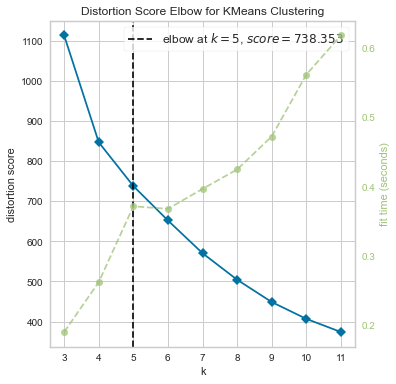

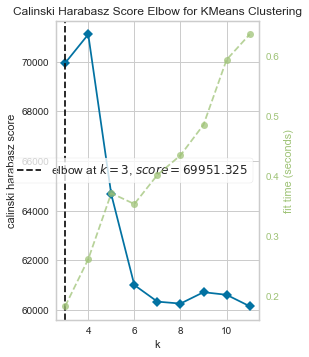

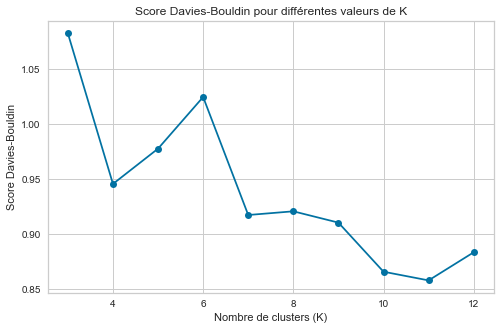

Meilleur K en fonction du score Davies-Bouldin: 11


In [22]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Définir différentes métriques pour la méthode de coude
metrics = ['distortion', 'calinski_harabasz']

# Créer une figure pour les graphiques
plt.figure(figsize=(12, 6))

# Créer une grille de visualisation avec les différentes métriques
for i, metric in enumerate(metrics):
    name = 'kelbowvisualizer_' + metric
    plt.subplot(1, 2, i+1)
    visualizer = KElbowVisualizer(KMeans(n_init=10, random_state=1), k=(3, 12), metric=metric)
    visualizer.fit(transformed_rfm)
    visualizer.show()

# Calculer le score Davies-Bouldin pour chaque valeur de K
davies_bouldin_scores = []
for k in range(3, 13):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1)
    labels = kmeans.fit_predict(transformed_rfm)
    davies_bouldin_scores.append(davies_bouldin_score(transformed_rfm, labels))

# Trouver le meilleur k en fonction du score Davies-Bouldin
best_k = davies_bouldin_scores.index(min(davies_bouldin_scores))+3

# Afficher le score Davies-Bouldin pour différentes valeurs de K
plt.figure(figsize=(8, 5))
plt.plot(range(3, 13), davies_bouldin_scores, marker='o')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('Score Davies-Bouldin')
plt.title('Score Davies-Bouldin pour différentes valeurs de K')
plt.grid(True)
plt.show()

print(f"Meilleur K en fonction du score Davies-Bouldin: {best_k}")

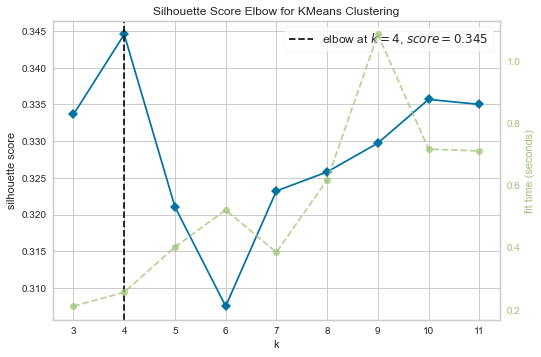

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [23]:
# Création d'un modèle K-means avec 10 initialisations
model = KMeans(n_init=10) # Cela spécifie le nombre de fois que l'algorithme K-means sera exécuté
# avec différentes initialisations pour choisir la meilleure solution.

visualizer = KElbowVisualizer(model, 
                              k=(3,12), #spécifiant la plage de valeurs de k à tester,
                              metric='silhouette',# Métrique Silhouette utilisée pour évaluer la qualité des cluster
                              timings=True) # afficher les temps d'exécution

visualizer.fit(transformed_rfm)
# Afficher le graphique représentant les Scores de silhouette pour différents nombres de clusters.
visualizer.poof()

Les différentes méthodes d'évaluation de clustering ont donné des résultats variés pour déterminer le nombre optimal de clusters (K) dans notre analyse de segmentation de clients. La méthode de distorsion a suggéré que K=5 est le meilleur choix, tandis que le score Calinski-Harabasz a identifié K=3 comme optimal. Le score Davies-Bouldin a abouti à K=8, et le score de silhouette a indiqué K=4.

La décision de choisir K=5 repose sur l'interprétation de la méthode de distorsion, qui cherche le "point du coude" où la distorsion commence à diminuer lentement. Cela peut être considéré comme un bon compromis entre la complexité du modèle (nombre de clusters) et la capacité à capturer les caractéristiques distinctes des segments de clients. Un nombre plus élevé de clusters peut conduire à un sur-ajustement (overfitting) des données, tandis qu'un nombre plus faible risque de regrouper des segments différents ensemble.

En respectant la méthode de distorsion, nous pouvons avoir un modèle de segmentation plus simple, avec cinq clusters, qui représente efficacement les différents comportements et caractéristiques de nos clients. Il est important de noter que le choix de K dépend également du contexte commercial et des objectifs spécifiques de l'analyse. Dans ce cas, K=5 semble être une valeur raisonnable et adaptée à nos besoins.

/Users/ismailcanoguz/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



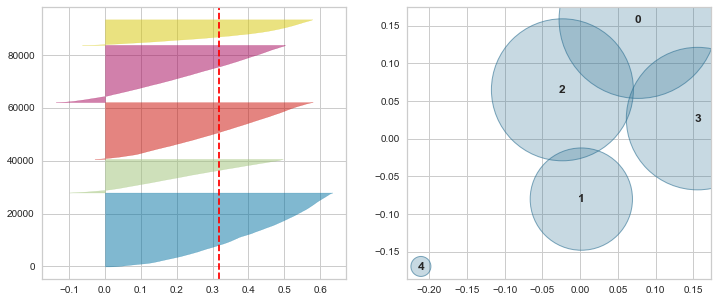

In [24]:
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance


# Initialiser le nombre de clusters à 5
K = 5

# Créer la figure pour les visualisations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Suppression du UserWarning
fig.set_tight_layout(False)

visualizer1 = SilhouetteVisualizer(KMeans(n_clusters=K, n_init=10, random_state=1), ax=axes[0], colors='yellowbrick')
visualizer1.fit(transformed_rfm)

visualizer2 = InterclusterDistance(KMeans(n_clusters=K, n_init=10, random_state=1), ax=axes[1], colors='yellowbrick')
visualizer2.fit(transformed_rfm)


# Afficher les visualisations
plt.show()

In [25]:
kmeans = KMeans(n_clusters = 5, n_init=10, random_state = 1) #fixer state afin d'obtenir des résultats reproductibles

kmeans.fit(transformed_rfm)

# Extraction des étiquettes de cluster
cluster_labels = kmeans.labels_

Les étiquettes de cluster attribuées à chaque client indiquent à quel groupe ils appartiennent, basé sur leurs caractéristiques RFM transformées. 

Cette étape nous permet d'analyser les caractéristiques des différents clusters de clients identifiés par l'algorithme K-means. Les moyennes de 'recency', 'frequency' et 'monetary' nous donnent un aperçu de la comportement moyen des clients dans chaque cluster. Le nombre de clients dans chaque cluster est également indiqué, ce qui nous donne une idée de la taille et de la répartition des segments de clients.

In [26]:
rfm_q = df_new[['recency', 'frequency', 'monetary']]

# Attribuer les étiquettes de 'Cluster'
rfm_q['Cluster'] = cluster_labels

# Effectuer l'opération de regroupement (groupby) sur le DataFrame
clusters_rfm = rfm_q.groupby(['Cluster']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(2)

display(clusters_rfm)

recency frequency monetary       
           mean      mean     mean  count
Cluster                                  
0        382.57      1.01    79.23  27942
1         91.79      1.06   286.32  12700
2        155.00      1.01    71.37  21449
3        310.46      1.08   356.55  21630
4         23.38      1.03   144.49   9637

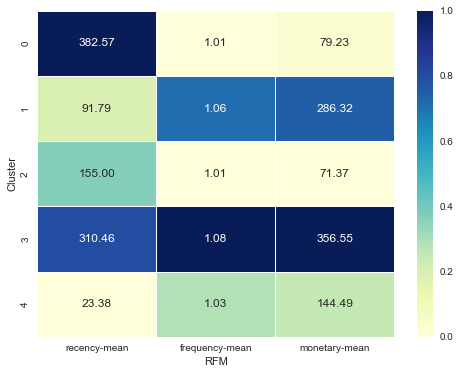

In [27]:
rfm_visu = clusters_rfm.iloc[:,:-1]

# Create a DataFrame
df_v = pd.DataFrame(rfm_visu)

# Normalize the data
normalized_df = (df_v - df_v.min()) / (df_v.max() - df_v.min())

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_df, cmap='YlGnBu', annot=df_v, fmt=".2f", linewidths=0.5)
plt.ylabel('Cluster')
plt.xlabel('RFM')
plt.show()


__Cluster 0: Clients à risque :__ Ces clients n'ont pas acheté récemment et ont un faible budget. Ils sont susceptibles de quitter si elle ne prend pas les mesures nécessaires pour les retenir.

__Cluster 1: Clients très fidèles :__ Ces clients ont une récence, une fréquence et une valeur monétaire élevées. Ils sont les clients les plus précieux pour l'entreprise et devraient être ciblés avec des offres et promotions spéciales.

__Cluster 2: Clients réguliers à petit budget :__ Ces clients n'ont pas un budget important, mais ils achètent régulièrement. Ils sont susceptibles de dépenser plus d'argent si l'entreprise leur propose des produits ou services adaptés à leurs besoins.

__Cluster 3: Clients potentiels :__ Ces clients n'ont pas acheté récemment, mais ils ont une fréquence et une valeur monétaire élevées. Ils sont susceptibles de devenir des clients réguliers si l'entreprise les cible avec des campagnes de marketing appropriées.

__Cluster 4: Nouveaux clients :__ Ces clients ont récemment acheté de l'entreprise. Ils devraient être ciblés avec des offres et promotions de bienvenue pour les encourager à continuer à faire des achats.

In [28]:
transformed_rfm

recency  frequency  monetary
0      0.718092        0.0  0.512667
1      0.722115        0.0  0.344968
2      0.956644        0.0  0.461659
3      0.878336        0.0  0.392412
4      0.861826        0.0  0.546304
...         ...        ...       ...
93353  0.928727        0.0  0.860356
93354  0.847427        0.0  0.459698
93355  0.965186        0.0  0.488833
93356  0.727318        0.0  0.506554
93357  0.940830        0.0  0.442647

[93358 rows x 3 columns]

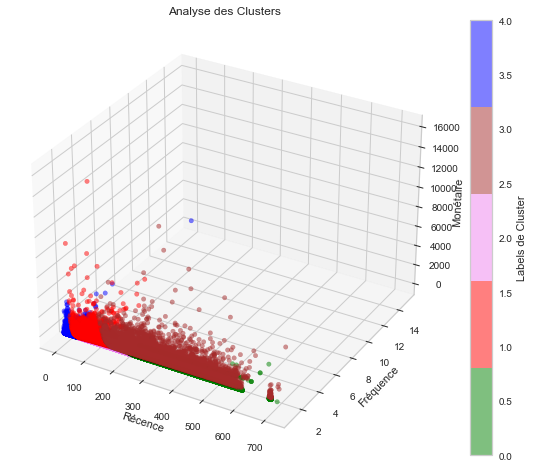

In [29]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# Définir une liste de cinq couleurs uniques
colors = ['green','red','violet','brown','blue']

# Créer une colormap avec les couleurs spécifiées
cmap = ListedColormap(colors)

# Créer un graphique en 3D avec des couleurs représentant les labels de clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Tracer les colonnes RFM transformées avec les labels de clusters
scatter = ax.scatter(rfm_q.iloc[:, 0], rfm_q.iloc[:, 1], rfm_q.iloc[:, 2], c=rfm_q['Cluster'], cmap=cmap, alpha=0.5)

# Ajouter une barre de couleur
cbar = plt.colorbar(scatter)
cbar.set_label('Labels de Cluster')

# Définir les étiquettes et le titre
ax.set_xlabel('Récence')
ax.set_ylabel('Fréquence')
ax.set_zlabel('Monétaire')
ax.set_title('Analyse des Clusters')

# Afficher le graphique
plt.show()

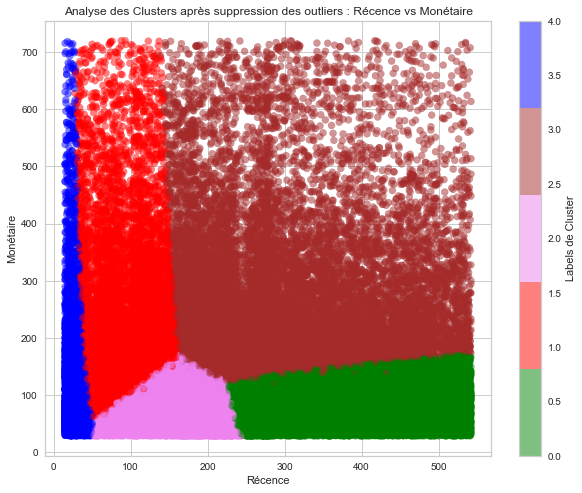

In [30]:
# Recherche et suppression des outliers dans les colonnes sélectionnées
outlier_indices = []
columns = [0, 2]  # Indices des colonnes à traiter

# Parcourir les colonnes sélectionnées
for i in columns:
    col = rfm_q.columns[i]
    # Calcul des limites des outliers (5e et 95e percentiles)
    percentile_5 = np.percentile(rfm_q[col], 3)
    percentile_95 = np.percentile(rfm_q[col], 97)
    # Ajout des indices des outliers à la liste outlier_indices
    outlier_indices.extend(rfm_q[(rfm_q[col] < percentile_5) | (rfm_q[col] > percentile_95)].index)

# Suppression des lignes correspondant aux outliers
rfm_filtered = rfm_q.drop(outlier_indices).reset_index(drop=True)

# Création d'un graphique pour visualiser les données après suppression des outliers
plt.figure(figsize=(10, 8))

# Tracer Récence versus Monétaire avec les labels de clusters sur les données filtrées
plt.scatter(rfm_filtered['recency'], rfm_filtered['monetary'], c=rfm_filtered['Cluster'], cmap=cmap, alpha=0.5)

# Ajouter une barre de couleur
cbar = plt.colorbar()
cbar.set_label('Labels de Cluster')

# Définir les étiquettes et le titre
plt.xlabel('Récence')
plt.ylabel('Monétaire')
plt.title('Analyse des Clusters après suppression des outliers : Récence vs Monétaire')

# Afficher le graphique
plt.show()

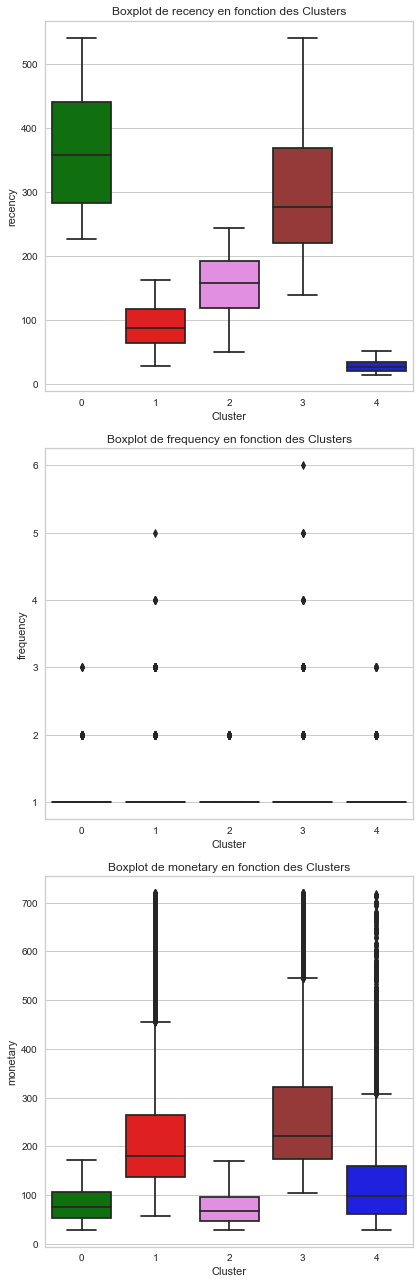

In [31]:
# Création d'un graphique en boîte (boxplot) pour chaque variable en fonction des clusters
plt.figure(figsize=(6, 18))

# Création des sous-traces pour chaque variable
for i, col in enumerate(rfm_filtered.columns[:-1]):
    plt.subplot(3, 1, i+1)
    sns.boxplot(x='Cluster', y=col, data=rfm_filtered, palette=colors)

    # Ajout des étiquettes d'axes et du titre pour chaque sous-trace
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.title(f'Boxplot de {col} en fonction des Clusters')

# Ajustement de l'espacement entre les sous-traces
plt.tight_layout()

# Affichage du graphique
plt.show()

In [32]:
cluster_labels

array([1, 2, 0, ..., 0, 1, 0], dtype=int32)

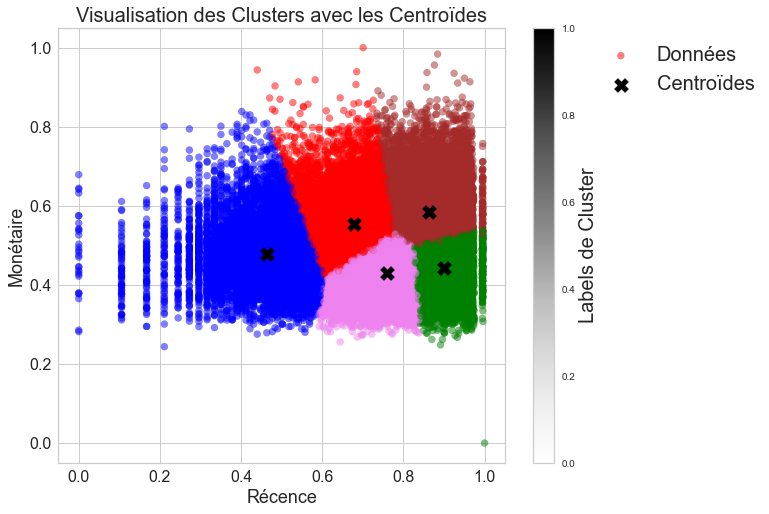

In [33]:
# Calcul des centroïdes pour chaque cluster
centroids = kmeans.cluster_centers_

# Création d'un graphique pour visualiser les centroïdes dans l'espace RFM
plt.figure(figsize=(10, 8))

# Tracer les points de données transformées
plt.scatter(transformed_rfm['recency'], transformed_rfm['monetary'], c=cluster_labels, cmap=cmap, alpha=0.5)

# Tracer les centroïdes des clusters
plt.scatter(centroids[:, 0], centroids[:, 2], marker='X', color='black', s=200, label='Centroïdes')

# Ajout d'une barre de couleur et des étiquettes des axes
cbar = plt.colorbar()
cbar.set_label('Labels de Cluster', fontsize=20)
plt.xlabel('Récence', fontsize=18)
plt.ylabel('Monétaire', fontsize=18)

# Déplacer la légende à l'extérieur du graphique
plt.legend(['Données', 'Centroïdes'], loc='upper right', bbox_to_anchor=(1.6, 1), fontsize=20)

# Titre du graphique
plt.title('Visualisation des Clusters avec les Centroïdes', fontsize=20)

# Augmenter la taille des ticks des axes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Affichage du graphique
plt.show()

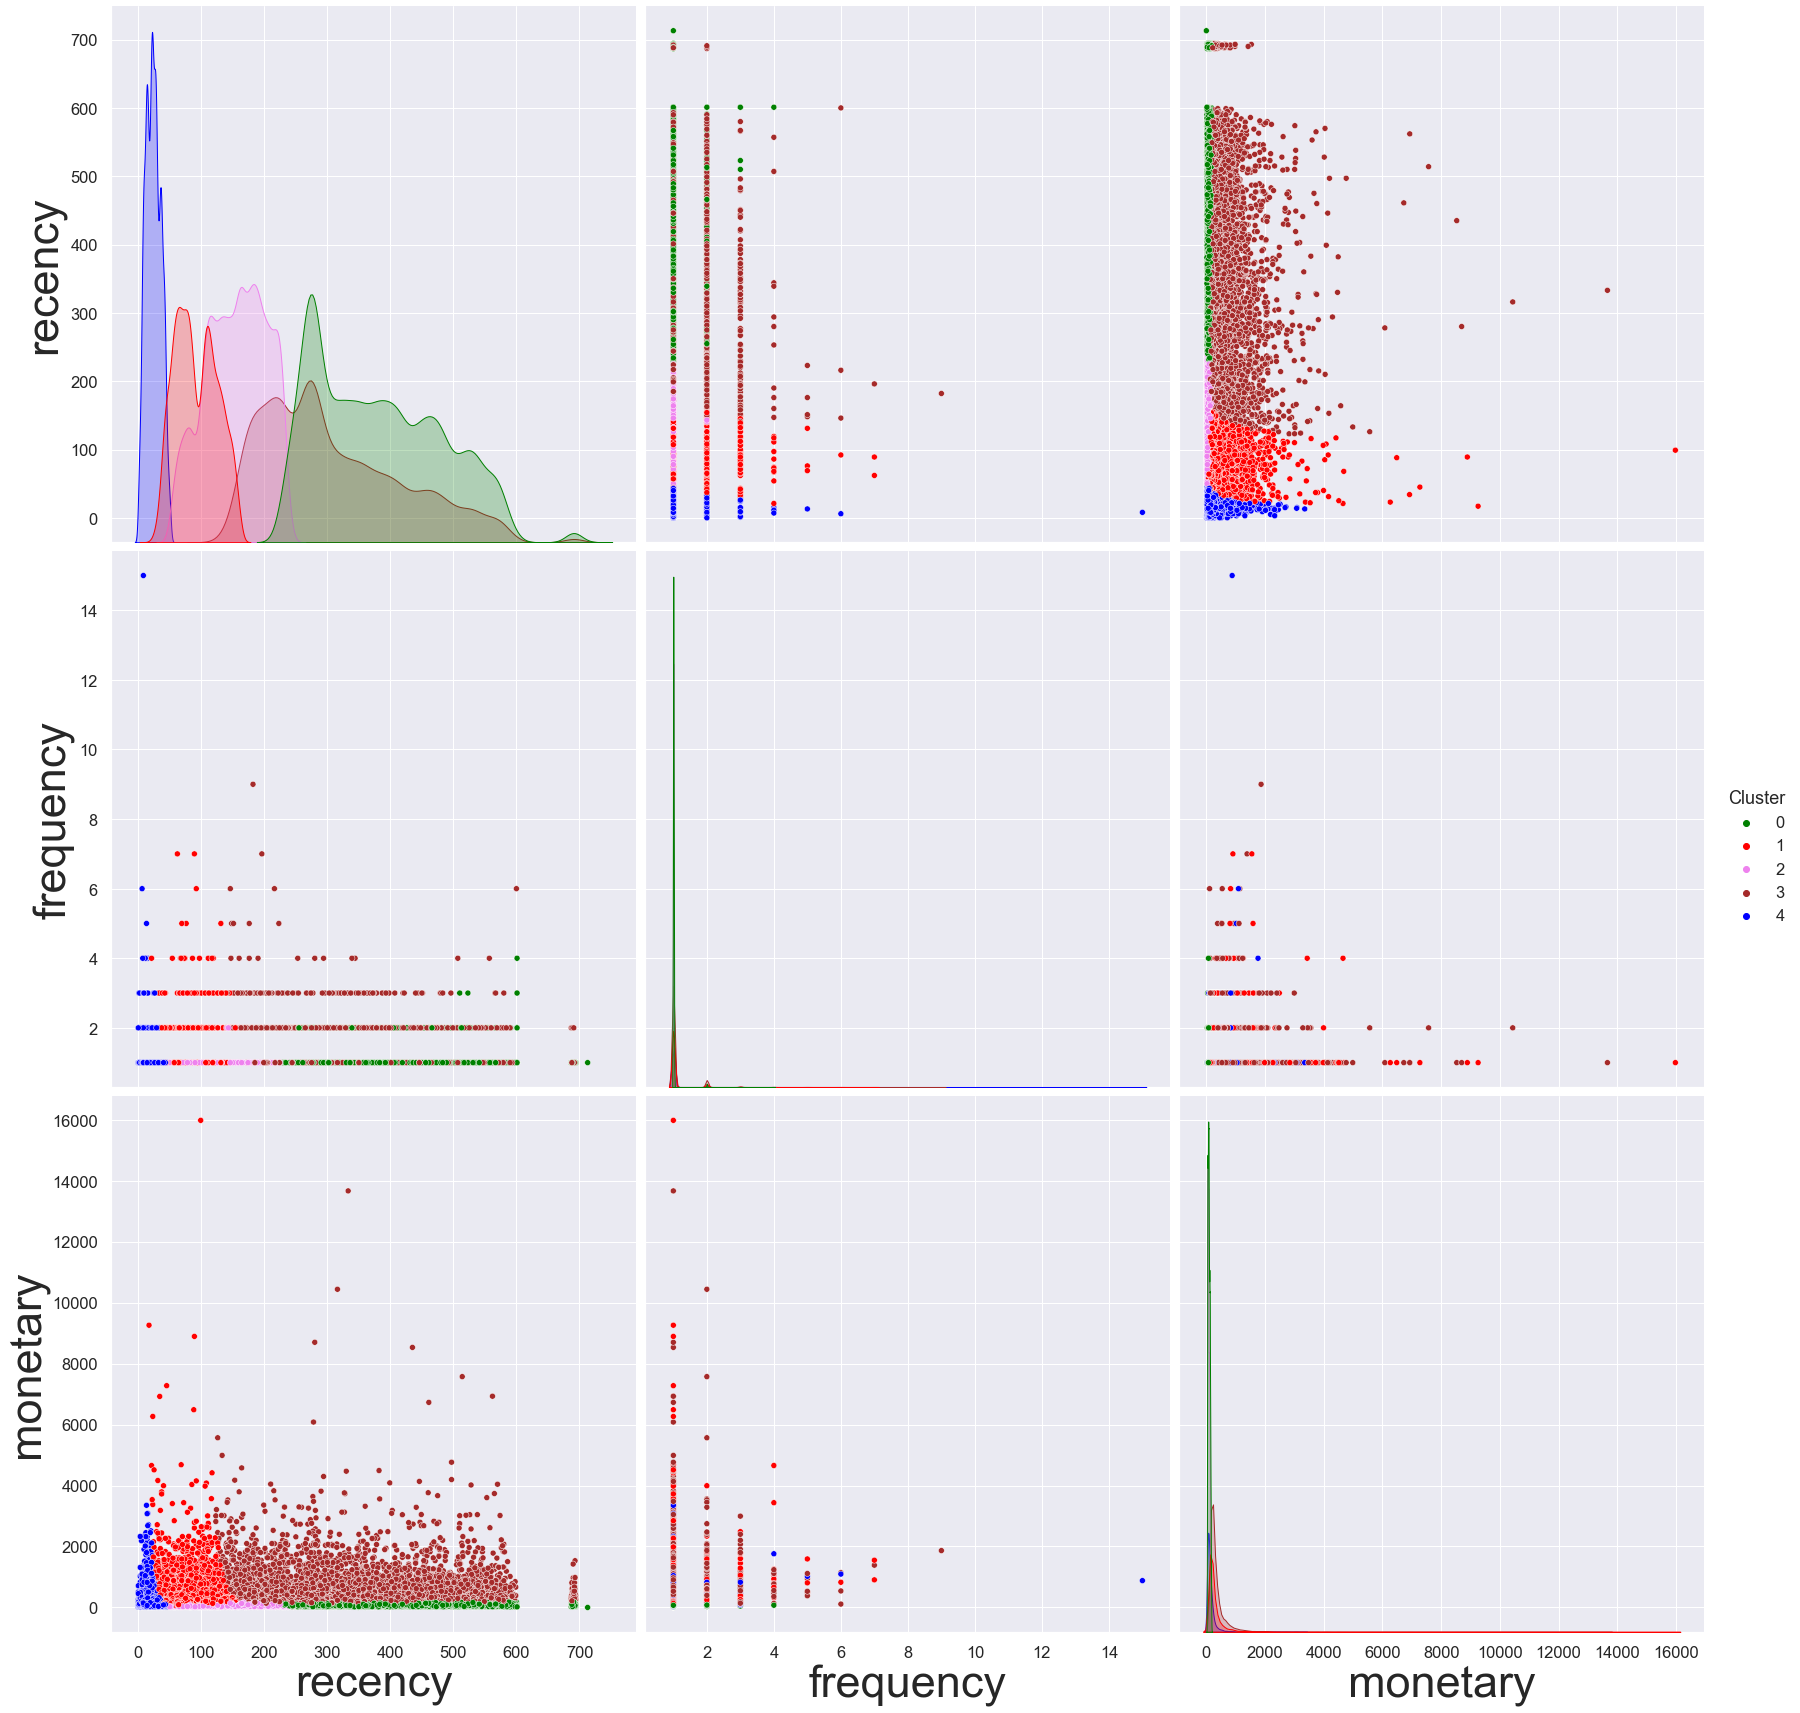

In [34]:
# Utiliser le même code couleur pour le pair plot en utilisant Seaborn
sns.set(font_scale=1.5)  # Augmenter la taille de la police pour le pair plot
g = sns.pairplot(rfm_q, hue="Cluster", palette=colors, height=8)  # Augmenter la taille du pair plot à 8 pouces

# Mettre à jour la taille de la police des étiquettes des axes
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=45)
    ax.set_ylabel(ax.get_ylabel(), fontsize=45)

# Afficher le pair plot avec la nouvelle taille de police
plt.show()

<a id='subsec:dbscan'></a>
### B. DBscan

In [35]:
rfm

recency  frequency  monetary  r_score  f_score  m_score  rfm_score  \
0          111          1    141.90        4        1        3        413   
1          536          1     86.22        1        1        2        112   
2          320          1     43.62        2        1        1        211   
3          287          1    196.89        2        1        4        214   
4          145          1    166.98        3        1        3        313   
...        ...        ...       ...      ...      ...      ...        ...   
82814      254          1     73.16        2        4        2        242   
82815      244          1    167.32        2        4        3        243   
82816      261          1     84.58        2        4        2        242   
82817      118          1    133.69        3        4        3        343   
82818      483          1     71.56        1        4        2        142   

         segmentation_client  
0           Nouveaux clients  
1             Clients perdus  
2             Clients perdus  
3             Clients perdus  
4             Clients perdus  
...                      ...  
82814  Risque élevé de churn  
82815  Risque élevé de churn  
82816  Risque élevé de churn  
82817       Client potentiel  
82818         Clients perdus  

[82819 rows x 8 columns]

In [36]:
from sklearn.neighbors import NearestNeighbors

# Sélectionner un sous-ensemble des données pour accélérer le traitement
rfm_reduced = transformed_rfm.iloc[:,:3].sample(15000)

# Adapter un modèle de voisins les plus proches pour calculer les distances entre les points de données
neigh = NearestNeighbors(n_neighbors=8000)
nbrs = neigh.fit(rfm_reduced)
distances, indices = nbrs.kneighbors(rfm_reduced)

Les distances sont ensuite triées par ordre croissant et tracées sur un graphique pour déterminer la valeur d'epsilon pour DBSCAN.

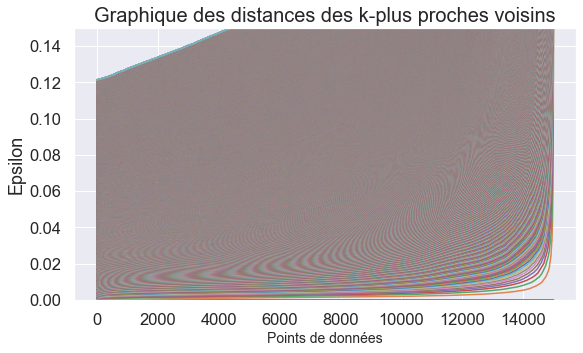

In [37]:
# Trier les distances par ordre croissant
distances = np.sort(distances, axis=0)

# Tracer les distances
plt.figure(figsize=(9,5))
plt.plot(distances)
plt.ylim([0, 0.15])
plt.title('Graphique des distances des k-plus proches voisins',fontsize=20)
plt.xlabel('Points de données',fontsize=14)
plt.ylabel('Epsilon')
plt.show()

Quant à la méthode des voisins les plus proches (Nearest Neighbors), elle est utilisée pour calculer les distances entre les points de données afin de déterminer la valeur d'epsilon pour DBSCAN. Cette valeur d'epsilon est cruciale pour définir le rayon de voisinage maximum lors de l'application de l'algorithme DBSCAN. En utilisant les voisins les plus proches, nous pouvons visualiser les distances entre les points et identifier un seuil approprié pour déterminer la densité des clusters. Cela aide à mieux définir les groupes de clients et à améliorer la précision du regroupement avec DBSCAN.

In [38]:
from sklearn.cluster import DBSCAN

# Effectuer le regroupement DBSCAN sur le sous-ensemble de données réduit
db3 = DBSCAN(eps=0.015
             , min_samples=20, n_jobs=-1).fit(rfm_reduced)

In [39]:
# Compter le nombre de clusters et de points de bruit
n_clusters_ = len(set(db3.labels_)) - (1 if -1 in db3.labels_ else 0)
n_noise_ = list(db3.labels_).count(-1)

print('Nombre de clusters: %d' % n_clusters_)
print('Nombre de points non classés: %d' % n_noise_)

Nombre de clusters: 3
Nombre de points non classés: 1684


In [40]:
# Compter la fréquence de chaque étiquette dans les résultats de regroupement
unique, counts = np.unique(db3.labels_, return_counts=True)
cluster_freq = dict(zip(unique, counts))
display(cluster_freq)

{-1: 1684, 0: 13227, 1: 69, 2: 20}

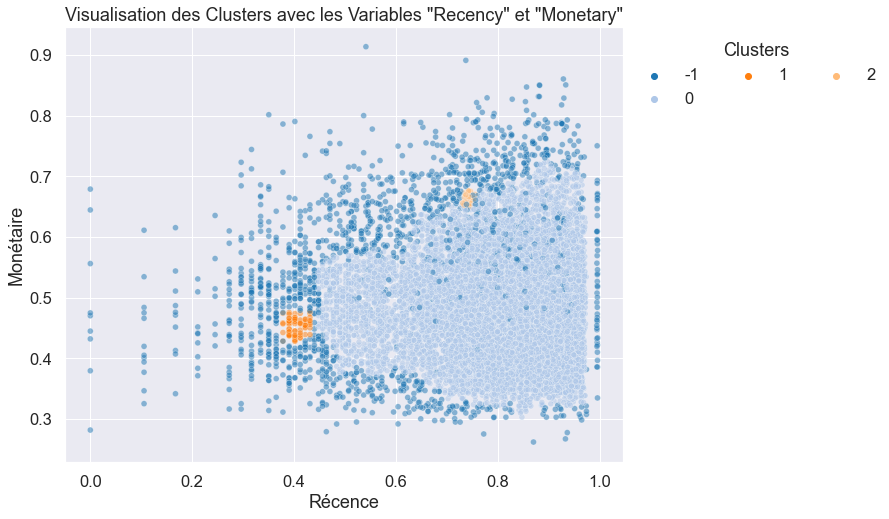

In [41]:
# Utilisation de la palette 'tab20' qui a 20 couleurs différentes
plt.figure(figsize=(10, 8))
plot = sns.scatterplot(
    x='recency', y='monetary',
    palette='tab20',
    data=rfm_reduced,
    hue=db3.labels_,
    alpha=0.5,
)

# Ajouter les étiquettes d'axes et le titre
plt.xlabel('Récence')
plt.ylabel('Monétaire')
plt.title('Visualisation des Clusters avec les Variables "Recency" et "Monetary"')

# Afficher la légende en dehors de la boîte du graphique avec trois colonnes
plt.legend(title='Clusters', loc='upper left', bbox_to_anchor=(1, 1), ncol=3)

# Affichage du graphique
plt.show()


<a id='subsec:ach'></a>
### C. CLASSIFICATION ASCENDANTE HIÉRARCHIQUE (CAH)



In [42]:
def plot_dendrogram(model, **kwargs):
    '''
    Affiche le dendrogramme d'un ensemble de données.
    
    Paramètres : 
        model : modèle pour la matrice de liaison (linkage matrix).
        **kwargs : paramètres pour le modèle.
        
    Renvoie :
        Affiche le dendrogramme.
    '''

    # Créer le compteur d'échantillons sous chaque nœud
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # nœud feuille
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Tracer le dendrogramme correspondant
    dendrogram(linkage_matrix, **kwargs)

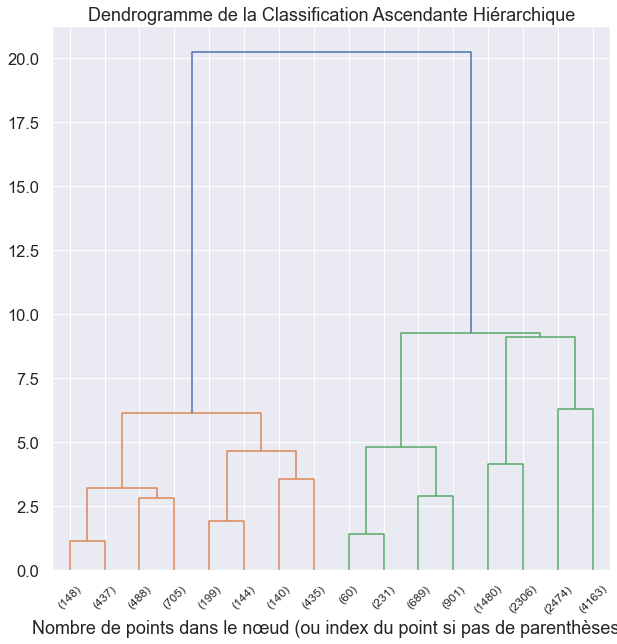

In [43]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Définir distance_threshold=0 pour obtenir l'arbre complet.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# Sélectionner les données
rfm_reduced = transformed_rfm.iloc[:,:3].sample(15000)

# Appliquer le modèle de classification ascendante hiérarchique (CAH) sur les données
model = model.fit(rfm_reduced)

# Créer la figure pour le dendrogramme
plt.figure(figsize=(10, 10))
plt.title('Dendrogramme de la Classification Ascendante Hiérarchique')

# Tracer les trois niveaux supérieurs du dendrogramme
plot_dendrogram(model, truncate_mode='level', p=3)

# Ajouter une étiquette pour l'axe des abscisses
plt.xlabel("Nombre de points dans le nœud (ou index du point si pas de parenthèses).")

# Faire pivoter les étiquettes de l'axe des abscisses pour une meilleure lisibilité
plt.xticks(rotation=45)

# Afficher le dendrogramme
plt.show()


Au sommet du dendrogramme, il y a un seul groupe représentant l'ensemble des points de données dans le jeu de données . En descendant le dendrogramme, les points de données commencent à se regrouper en clusters. Les nombres entre parenthèses montrent le nombre de points de données présents dans chaque cluster à ce niveau spécifique.

La hauteur à laquelle les branches se rejoignent représente la similarité entre les clusters. Les branches plus basses indiquent que les clusters sont plus similaires les uns aux autres, tandis que les branches plus hautes indiquent que les clusters sont plus distincts.

La méthode de classification ascendante hiérarchique (CAH) présente certaines limites pour la segmentation des clients. Comme on peut le voir dans le dendrogramme, il y a de nombreuses branches et niveaux de similarité, ce qui peut rendre difficile l'interprétation des résultats et la compréhension des regroupements de clients. Dans notre cas, nous cherchons à identifier des segments distincts et significatifs de clients, mais le grand nombre de branches dans le dendrogramme rend cette tâche complexe.

Dans notre projet, nous cherchons une segmentation de clients avec quelques clusters significatifs et facilement interprétables. C'est pourquoi nous allons explorer d'autres approches de clustering, telles que K-means, qui peuvent nous donner des résultats plus appropriés pour notre analyse. Ces approches nous permettront d'obtenir une segmentation plus concise et plus pertinente pour notre objectif de compréhension des comportements des clients et de personnalisation des stratégies de marketing.

<a id='sec:segmentation-rfm-satisfaction-client'></a>
## IV. Segmentation RFM + Satisfaction Client avec Machine Learning

In [44]:
rfmS = df_new[["recency","frequency", "monetary","review_score"]]

rfmS.rename(columns={'review_score': 'satisfaction'},
           inplace=True)

In [45]:
display(rfmS)

recency  frequency  monetary  satisfaction
0          111          1    141.90           5.0
1          114          1     27.19           4.0
2          536          1     86.22           3.0
3          320          1     43.62           4.0
4          287          1    196.89           5.0
...        ...        ...       ...           ...
93353      446          1   4134.84           5.0
93354      261          1     84.58           4.0
93355      567          1    112.46           5.0
93356      118          1    133.69           5.0
93357      483          1     71.56           5.0

[93358 rows x 4 columns]

In [46]:
rfmS.isna().sum()

recency           0
frequency         0
monetary          0
satisfaction    603
dtype: int64

In [47]:
# Calculer la moyenne de la colonne "satisfaction"
satisfaction_mean = rfmS['satisfaction'].mean()

# Remplir les valeurs manquantes dans la colonne "satisfaction" avec la valeur moyenne
rfmS['satisfaction'].fillna(satisfaction_mean, inplace=True)


In [48]:
# Sélection des variables RFM
rfmS_log = rfmS.copy()

# Application du logarithme à recency, frequency, monetary, and satisfaction
rfmS_log['recency'] = np.log1p(rfmS_log['recency'])
rfmS_log['frequency'] = np.log1p(rfmS_log['frequency'])
rfmS_log['monetary'] = np.log1p(rfmS_log['monetary'])
rfmS_log['satisfaction'] = np.log1p(rfmS_log['satisfaction'])

# Utilisation de MinMaxScaler pour normaliser les données
scaler = MinMaxScaler()
transformed_rfmS = scaler.fit_transform(rfmS_log)

# Conversion en DataFrame avec les nouvelles valeurs normalisées
transformed_rfmS = pd.DataFrame(transformed_rfmS, columns=['recency', 'frequency', 'monetary', 'satisfaction'])


array([[<AxesSubplot: title={'center': 'recency'}>,
        <AxesSubplot: title={'center': 'frequency'}>],
       [<AxesSubplot: title={'center': 'monetary'}>,
        <AxesSubplot: title={'center': 'satisfaction'}>]], dtype=object)

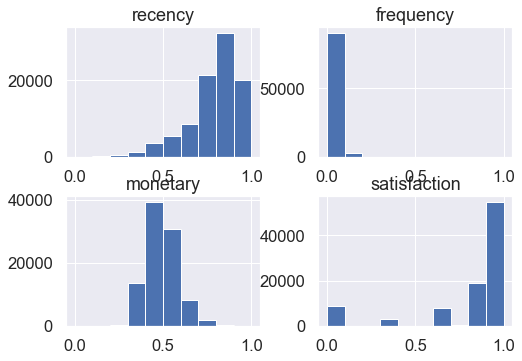

In [49]:
transformed_rfmS.hist()

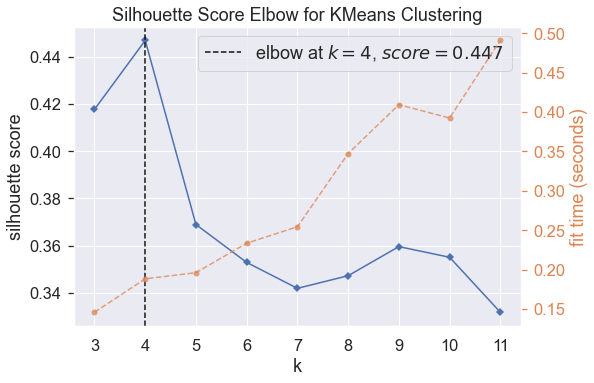

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [50]:
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, 
                              k=(3,12),
                              metric='silhouette', 
                              timings=True)

visualizer.fit(transformed_rfmS)
visualizer.poof()

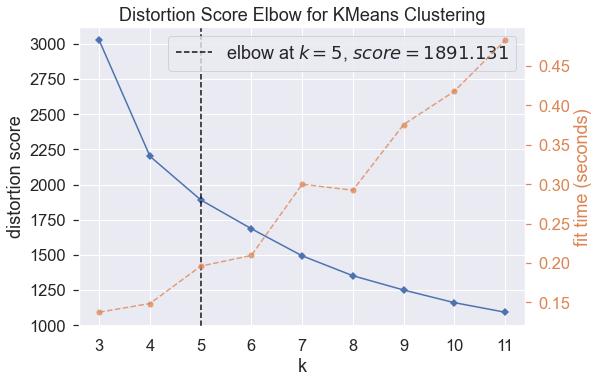

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [51]:
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model,
                              k=(3, 12))

visualizer.fit(transformed_rfmS)
visualizer.poof()

/Users/ismailcanoguz/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



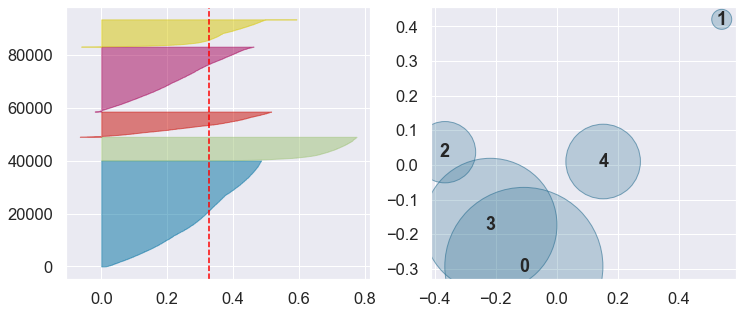

In [52]:
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance


# Initialiser le nombre de clusters à 5
K = 5

# Créer la figure pour les visualisations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Suppression du UserWarning
fig.set_tight_layout(False)

visualizer1 = SilhouetteVisualizer(KMeans(n_clusters=K, n_init=10, random_state=1), ax=axes[0], colors='yellowbrick')
visualizer1.fit(transformed_rfmS)

visualizer2 = InterclusterDistance(KMeans(n_clusters=K, n_init=10, random_state=1), ax=axes[1], colors='yellowbrick')
visualizer2.fit(transformed_rfmS)


# Afficher les visualisations
plt.show()

In [53]:
kmeans = KMeans(n_clusters = 5, n_init=10, random_state = 1) #fixer state afin d'obtenir des résultats reproductibles

kmeans.fit(transformed_rfmS)

# Extraction des étiquettes de cluster
cluster_labels = kmeans.labels_

In [54]:
# Attribuer les étiquettes de 'Cluster'
rfmS['Cluster'] = cluster_labels

# Effectuer l'opération de regroupement (groupby) sur le DataFrame
clusters_rfmS = rfmS.groupby(['Cluster']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'satisfaction': 'mean'
}).round(2)

# Calculer le compte séparément
clusters_rfmS['count'] = rfmS.groupby('Cluster')['satisfaction'].count()

display(clusters_rfmS)




recency  frequency  monetary  satisfaction  count
Cluster                                                   
0         352.53       1.03    166.34          4.74  40051
1         233.70       1.02    229.91          1.00   8944
2          24.96       1.04    172.91          4.68   9524
3         124.42       1.04    171.92          4.75  24526
4         254.22       1.05    184.62          2.73  10313

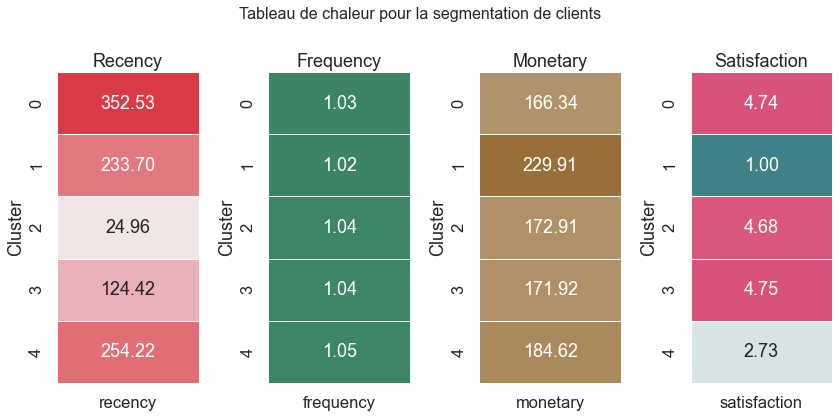

In [55]:
# Create diverging colormaps for each column
cmap_recency = sns.diverging_palette(250, 10, as_cmap=True)
cmap_frequency = sns.diverging_palette(150, 20, as_cmap=True)
cmap_monetary = sns.diverging_palette(300, 50, as_cmap=True)
cmap_satisfaction = sns.diverging_palette(200, 0, as_cmap=True)

# Plot the heatmaps for each column separately
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
sns.heatmap(clusters_rfmS[['recency']], cmap=cmap_recency, annot=True, fmt=".2f", linewidths=0.5, center=3, cbar=False)
plt.title('Recency')

plt.subplot(1, 4, 2)
sns.heatmap(clusters_rfmS[['frequency']], cmap=cmap_frequency, annot=True, fmt=".2f", linewidths=0.5, center=3, cbar=False)
plt.title('Frequency')

plt.subplot(1, 4, 3)
sns.heatmap(clusters_rfmS[['monetary']], cmap=cmap_monetary, annot=True, fmt=".2f", linewidths=0.5, center=3, cbar=False)
plt.title('Monetary')

plt.subplot(1, 4, 4)
sns.heatmap(clusters_rfmS[['satisfaction']], cmap=cmap_satisfaction, annot=True, fmt=".2f", linewidths=0.5, center=3, cbar=False)
plt.title('Satisfaction')

plt.suptitle('Tableau de chaleur pour la segmentation de clients', fontsize=16)
plt.tight_layout()
plt.show()







__Cluster 0 : Clients Satisfaits__

Explication : Les clients de ce groupe sont hautement satisfaits de leurs achats.

__Cluster 1 : Gros Dépensiers Insatisfaits__

Explication : Les clients de ce groupe dépensent beaucoup, mais ne sont pas satisfaits de leurs achats.

__Cluster 2 : Clients Récents Satisfaits__

Explication : Les clients de ce groupe ont effectué des achats récemment et sont satisfaits de leurs achats.

__Cluster 3 : Clients Actifs Satisfaits__

Explication : Les clients de ce groupe sont actifs et font régulièrement des achats, et ils sont satisfaits de leurs achats.

__Cluster 4 : Clients Inactifs Mécontents__

Explication : Les clients de ce groupe sont inactifs depuis un certain temps et ne sont pas satisfaits de leurs achats précédents.

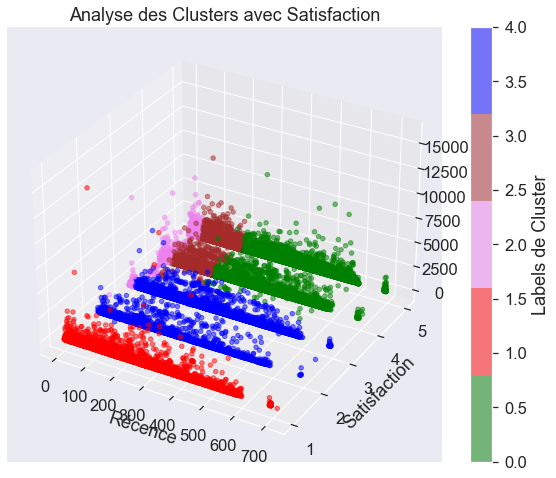

In [56]:
# Define a list of five unique colors
colors = ['green','red','violet','brown','blue']

# Create a colormap with the specified colors
cmap = ListedColormap(colors)

# Create a 3D scatter plot with colors representing cluster labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the transformed RFM columns with cluster labels
scatter = ax.scatter(rfmS.iloc[:, 0], rfmS.iloc[:, 3], rfmS.iloc[:, 2], c=cluster_labels, cmap=cmap, alpha=0.5)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Labels de Cluster')

# Set labels and title
ax.set_xlabel('Récence')
ax.set_ylabel('Satisfaction')
ax.set_zlabel('')
ax.set_title('Analyse des Clusters avec Satisfaction')

# Show the plot
plt.show()


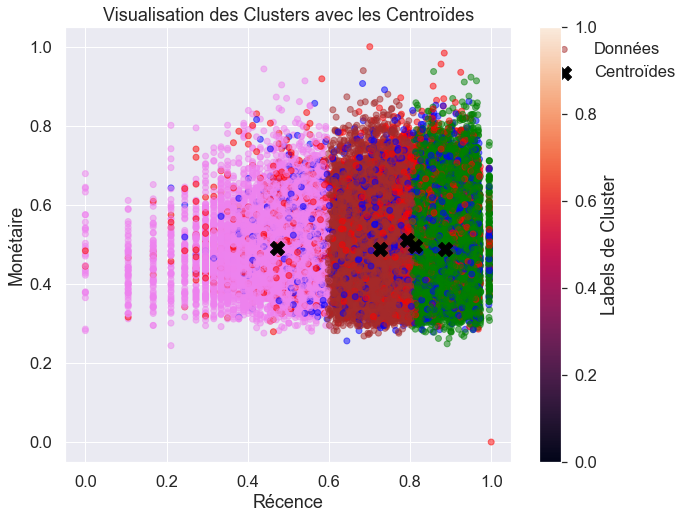

In [57]:
# Calcul des centroïdes pour chaque cluster
centroids = kmeans.cluster_centers_

# Création d'un graphique pour visualiser les centroïdes dans l'espace RFM
plt.figure(figsize=(10, 8))

# Tracer les points de données transformées
plt.scatter(transformed_rfmS['recency'], transformed_rfmS['monetary'], c=cluster_labels, cmap=cmap, alpha=0.5)

# Tracer les centroïdes des clusters
plt.scatter(centroids[:, 0], centroids[:, 2], marker='X', color='black', s=200, label='Centroïdes')

# Ajout d'une barre de couleur et des étiquettes des axes
cbar = plt.colorbar()
cbar.set_label('Labels de Cluster')
plt.xlabel('Récence')
plt.ylabel('Monétaire')

# Déplacer la légende à l'extérieur du graphique
plt.legend(['Données', 'Centroïdes'], loc='upper right', bbox_to_anchor=(1.4, 1))

# Titre du graphique
plt.title('Visualisation des Clusters avec les Centroïdes')

# Affichage du graphique
plt.show()

In [58]:
transformed_rfmS

recency  frequency  monetary  satisfaction
0      0.718092        0.0  0.512667      1.000000
1      0.722115        0.0  0.344968      0.834044
2      0.956644        0.0  0.461659      0.630930
3      0.878336        0.0  0.392412      0.834044
4      0.861826        0.0  0.546304      1.000000
...         ...        ...       ...           ...
93353  0.928727        0.0  0.860356      1.000000
93354  0.847427        0.0  0.459698      0.834044
93355  0.965186        0.0  0.488833      1.000000
93356  0.727318        0.0  0.506554      1.000000
93357  0.940830        0.0  0.442647      1.000000

[93358 rows x 4 columns]

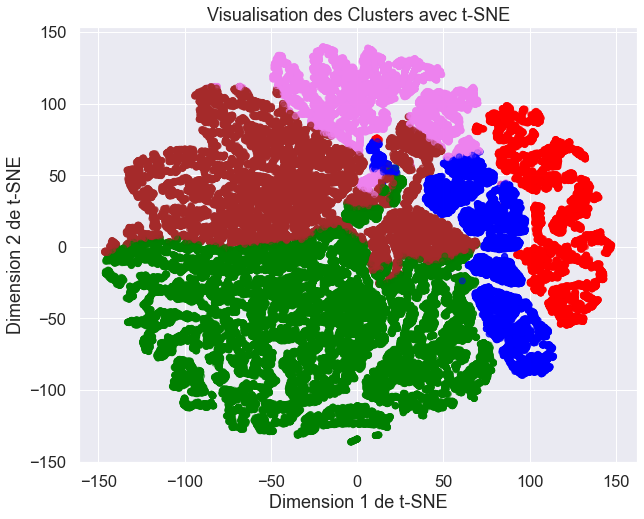

In [59]:
from sklearn.manifold import TSNE

# Réaliser une réduction en 2 dimensions avec t-SNE sur le jeu de données transformed_rfmS
tsne = TSNE(n_components=2, random_state=1)
tsne_data = tsne.fit_transform(transformed_rfmS)

# Ajouter les résultats de t-SNE dans une nouvelle DataFrame
tsne_df = pd.DataFrame(data=tsne_data, columns=['tsne_1', 'tsne_2'])

# Obtenir les étiquettes de clusters à partir du modèle KMeans
cluster_labels = kmeans.labels_

# Créer un graphique de dispersion pour visualiser les points de données transformés avec t-SNE et leurs clusters
plt.figure(figsize=(10, 8))

# Tracer les points de données avec différentes couleurs représentant les différents clusters
# 'c=cluster_labels' permet de faire correspondre les étiquettes de clusters à des couleurs en utilisant la colormap (cmap) spécifiée
plt.scatter(tsne_df['tsne_1'], tsne_df['tsne_2'], c=cluster_labels, cmap=cmap, alpha=0.5)

# Ajouter les étiquettes des axes pour les dimensions t-SNE
plt.xlabel('Dimension 1 de t-SNE')
plt.ylabel('Dimension 2 de t-SNE')

# Ajouter un titre au graphique
plt.title('Visualisation des Clusters avec t-SNE')

# Afficher le graphique
plt.show()

<a id='sec:segmentation-rfm-satisfaction-client-autres-variables-acp'></a>
## V. Segmentation RFM + satisfaction client + autres variables avec une approche de Machine Learning + ACP + t-SNE

In [60]:
display(df_new)

customer_unique_id  frequency order_purchase_timestamp  \
0      0000366f3b9a7992bf8c76cfdf3221e2          1      2018-05-10 10:56:27   
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1      2018-05-07 11:11:27   
2      0000f46a3911fa3c0805444483337064          1      2017-03-10 21:05:03   
3      0000f6ccb0745a6a4b88665a16c9f078          1      2017-10-12 20:29:41   
4      0004aac84e0df4da2b147fca70cf8255          1      2017-11-14 19:45:42   
...                                 ...        ...                      ...   
93353  fffcf5a5ff07b0908bd4e2dbc735a684          1      2017-06-08 21:00:36   
93354  fffea47cd6d3cc0a88bd621562a9d061          1      2017-12-10 20:07:56   
93355  ffff371b4d645b6ecea244b27531430a          1      2017-02-07 15:49:16   
93356  ffff5962728ec6157033ef9805bacc48          1      2018-05-02 15:17:41   
93357  ffffd2657e2aad2907e67c3e9daecbeb          1      2017-05-02 20:18:45   

       recency customer_state prefered_payment  tot_product  \
0          111             SP      credit_card            1   
1          114             SP      credit_card            1   
2          536             SC      credit_card            1   
3          320             PA      credit_card            1   
4          287             SP      credit_card            1   
...        ...            ...              ...          ...   
93353      446             PE      credit_card            4   
93354      261             BA      credit_card            1   
93355      567             MT      credit_card            1   
93356      118             ES      credit_card            1   
93357      483             PR      credit_card            1   

       most_frequent_number_of_payments  monetary  review_score  \
0                                   8.0    141.90           5.0   
1                                   1.0     27.19           4.0   
2                                   8.0     86.22           3.0   
3                                   4.0     43.62           4.0   
4                                   6.0    196.89           5.0   
...                                 ...       ...           ...   
93353                              10.0   4134.84           5.0   
93354                               1.0     84.58           4.0   
93355                               1.0    112.46           5.0   
93356                               5.0    133.69           5.0   
93357                               4.0     71.56           5.0   

       product_category_name  
0                          1  
1                          1  
2                          1  
3                          1  
4                          1  
...                      ...  
93353                      1  
93354                      1  
93355                      1  
93356                      1  
93357                      1  

[93358 rows x 11 columns]

In [61]:
# Calculer la moyenne de review_score
df_mean_review_score = df_new.review_score.mean()

# Remplir les valeurs manquantes de review_score avec la moyenne
df_new.review_score = df_new.review_score.fillna(df_mean_review_score)

In [62]:
df_new.set_index('customer_unique_id', inplace=True)

In [63]:
X = df_new.drop(columns=['order_purchase_timestamp','customer_state']) 

In [64]:
# Calculer la moyenne de review_score
mean_review_score = X.review_score.mean()

# Remplir les valeurs manquantes de review_score avec la moyenne
X.review_score = X.review_score.fillna(mean_review_score)

# Remplir les valeurs manquantes de most_frequent_number_of_payments avec 1 (si elles sont encore manquantes)
X.most_frequent_number_of_payments = X.most_frequent_number_of_payments.fillna(1)


In [65]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Define the column transformer for numerical and categorical columns
numerical_cols = X.select_dtypes(['int64', 'float64']).columns
categorical_cols = X.select_dtypes(['object']).columns

ct = ColumnTransformer([
    ('numeric', StandardScaler(), numerical_cols),
    ('categorical', OneHotEncoder(), categorical_cols)
])


# Fit and transform the data
X_scaled = ct.fit_transform(X)

# Get the transformed column names for categorical columns
categorical_encoder = ct.named_transformers_['categorical']
categorical_feature_names = categorical_encoder.get_feature_names_out(categorical_cols)

# Combine numerical column names with transformed categorical column names
column_names = numerical_cols.tolist() + categorical_feature_names.tolist()

# Create a DataFrame using the transformed data and column names
X_scaled = pd.DataFrame(X_scaled, columns=column_names)

display(X_scaled.head(10))

frequency   recency  tot_product  most_frequent_number_of_payments  \
0  -0.159829 -0.825357    -0.056618                          1.880700   
1  -0.159829 -0.805697    -0.056618                         -0.704768   
2  -0.159829  1.959873    -0.056618                          1.880700   
3  -0.159829  0.544321    -0.056618                          0.403290   
4  -0.159829  0.328056    -0.056618                          1.141995   
5  -0.159829 -0.602539    -0.056618                          1.880700   
6  -0.159829 -0.694288    -0.056618                         -0.704768   
7  -0.159829 -0.360060     0.211502                          0.033937   
8  -0.159829  1.999194    -0.056618                          0.033937   
9  -0.159829 -0.445255    -0.056618                          0.403290   

   monetary  review_score  product_category_name  prefered_payment_boleto  \
0 -0.129101      0.663326              -0.151728                      0.0   
1 -0.556071     -0.120204              -0.151728                      0.0   
2 -0.336351     -0.903733              -0.151728                      0.0   
3 -0.494915     -0.120204              -0.151728                      0.0   
4  0.075581      0.663326              -0.151728                      0.0   
5 -0.035749     -0.120204              -0.151728                      0.0   
6 -0.525586     -0.120204              -0.151728                      1.0   
7  2.463240     -2.470792              -0.151728                      0.0   
8 -0.098505     -0.120204              -0.151728                      0.0   
9 -0.174288     -2.470792              -0.151728                      0.0   

   prefered_payment_credit_card  prefered_payment_debit_card  \
0                           1.0                          0.0   
1                           1.0                          0.0   
2                           1.0                          0.0   
3                           1.0                          0.0   
4                           1.0                          0.0   
5                           1.0                          0.0   
6                           0.0                          0.0   
7                           1.0                          0.0   
8                           1.0                          0.0   
9                           1.0                          0.0   

   prefered_payment_voucher  prefered_payment_nan  
0                       0.0                   0.0  
1                       0.0                   0.0  
2                       0.0                   0.0  
3                       0.0                   0.0  
4                       0.0                   0.0  
5                       0.0                   0.0  
6                       0.0                   0.0  
7                       0.0                   0.0  
8                       0.0                   0.0  
9                       0.0                   0.0

In [66]:
X_scaled['prefered_payment_credit_card'].value_counts()

prefered_payment_credit_card
1.0    70785
0.0    22573
Name: count, dtype: int64

<a id='subsec:acp'></a>
### ACP (Analyse en Composantes Principales)

In [67]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    '''
    Trace les cercles de corrélations 
    '''
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(
                    LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i],
                                 fontsize='14', ha='center',
                                 va='center', rotation=label_rotation,
                                 color="black", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.axis('square')
            plt.grid(True)
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            plt.show()
            
def display_factorial_planes(X_projected, n_comp, pca,
                             axis_ranks,couleurs = None,
                             labels=None,
                             n_cols=3, alpha=1,
                             illustrative_var=None, lab_on = True, size= 10):
     for i, (d1, d2) in (enumerate(axis_ranks)):
        if d2 < n_comp:
 
            # initialisation de la figure 
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha, s=size)
            else:
                illustrative_var = np.array(illustrative_var)
                label_patches = []
                colors = couleurs
                i=0
                
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value,
                                c= colors[i])
                    label_patch = mpatches.Patch(color=colors[i],
                                                 label=value)
                    label_patches.append(label_patch)
                    i += 1
                    ax.legend(
                        handles=label_patches,
                        bbox_to_anchor=(
                            1.05,
                            1),
                        loc=2,
                        borderaxespad=0.,
                        facecolor='white')
                plt.legend()

            # affichage des labels des points
            if labels is not None and lab_on:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            #plt.grid(False)

def display_scree_plot(pca):
    taux_var_exp = pca.explained_variance_ratio_
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    ax1 = plt.gca()
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.axhline(y=90,color='r')
    plt.text(2, 92, '>90%', color='r', fontsize=10)
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    for i, p in enumerate(ax1.patches):
        ax1.text(
            p.get_width() /
            5 +
            p.get_x(),
            p.get_height() +
            p.get_y() +
            0.3,
            '{:.0f}%'.format(
                taux_var_exp[i] *
                100),
            fontsize=8,
            color='k')
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

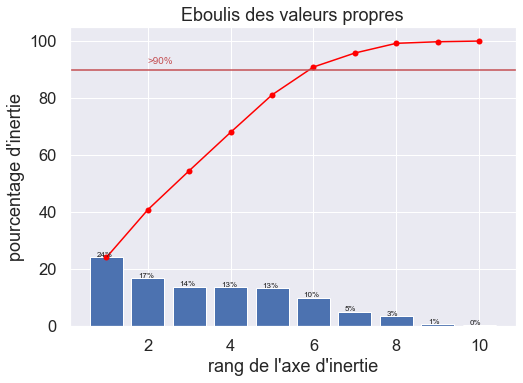

In [68]:
from sklearn.decomposition import PCA

# Calculate principal components
n_comp = 10
pca = PCA(n_components=n_comp, random_state=1)
pca.fit(X_scaled)

# Scree plot
display_scree_plot(pca)

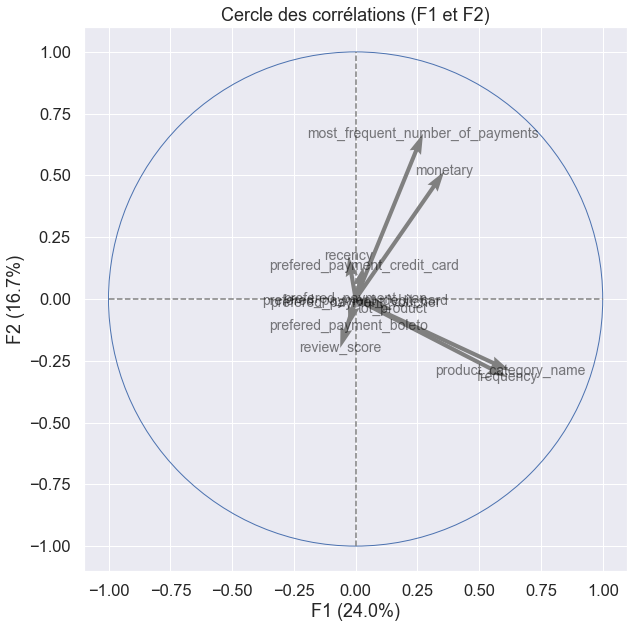

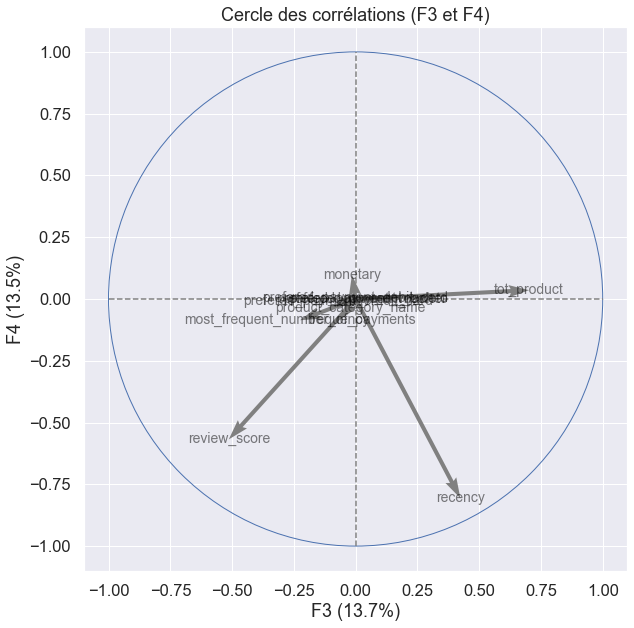

In [69]:
# Affichage du cercle des corrélations
features = X_scaled.columns
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0, 1),(2,3)], labels = np.array(features))

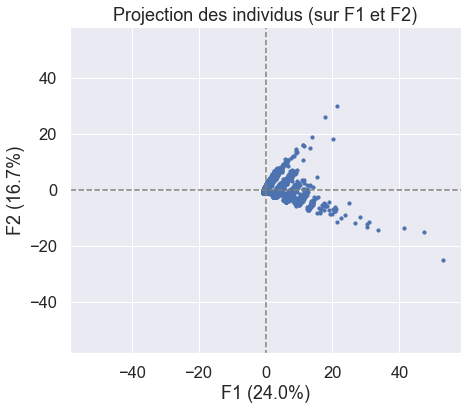

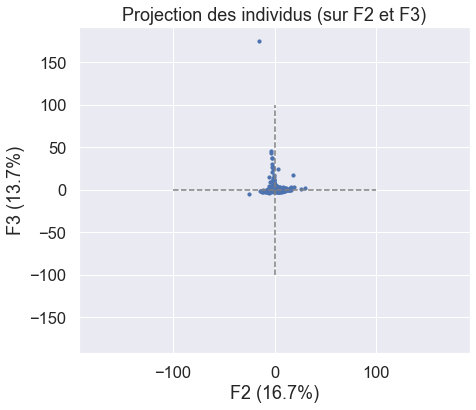

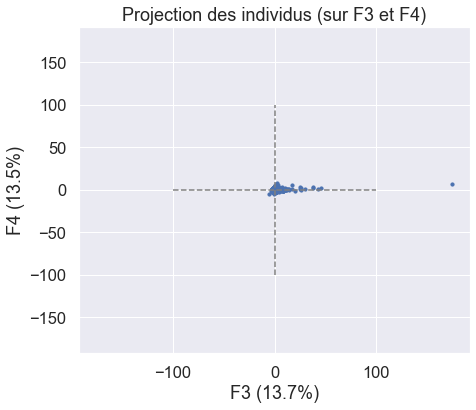

In [70]:
X_r_projected = pca.transform(X_scaled)
display_factorial_planes(X_r_projected, n_comp, pca, [(0,1),(1,2),(2,3)])

In [71]:
X_scaled['prefered_payment_credit_card']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
93353    1.0
93354    1.0
93355    1.0
93356    1.0
93357    1.0
Name: prefered_payment_credit_card, Length: 93358, dtype: float64

In [72]:
# Créer un nouveau DataFrame RFM en extrayant les colonnes nécessaires de X_scaled
RFM = pd.DataFrame()

# Extraire les colonnes "recency", "frequency" et "monetary" de X_scaled
RFM['recency'] = X_scaled['recency']
RFM['frequency'] = X_scaled['frequency']
RFM['monetary'] = X_scaled['monetary']

# Ajouter les colonnes "satisfaction", "tot_product" et "prefered_payment_credit_card" à partir de X_scaled
RFM['satisfaction'] = X_scaled['review_score']
RFM['tot_product'] = X_scaled['tot_product']
RFM['prefered_payment_credit_card'] = X_scaled['prefered_payment_credit_card']

# Renommer le DataFrame RFM en RFM_new
RFM_new = RFM.rename(columns={
    'recency': 'recency',
    'frequency': 'frequency',
    'monetary': 'monetary',
    'satisfaction': 'satisfaction',
    'tot_product': 'tot_product',
    'prefered_payment_credit_card': 'prefered_payment_credit_card'
})

# Afficher les premières lignes du nouveau jeu de données RFM_new
display(RFM_new.head())


recency  frequency  monetary  satisfaction  tot_product  \
0 -0.825357  -0.159829 -0.129101      0.663326    -0.056618   
1 -0.805697  -0.159829 -0.556071     -0.120204    -0.056618   
2  1.959873  -0.159829 -0.336351     -0.903733    -0.056618   
3  0.544321  -0.159829 -0.494915     -0.120204    -0.056618   
4  0.328056  -0.159829  0.075581      0.663326    -0.056618   

   prefered_payment_credit_card  
0                           1.0  
1                           1.0  
2                           1.0  
3                           1.0  
4                           1.0

<AxesSubplot: >

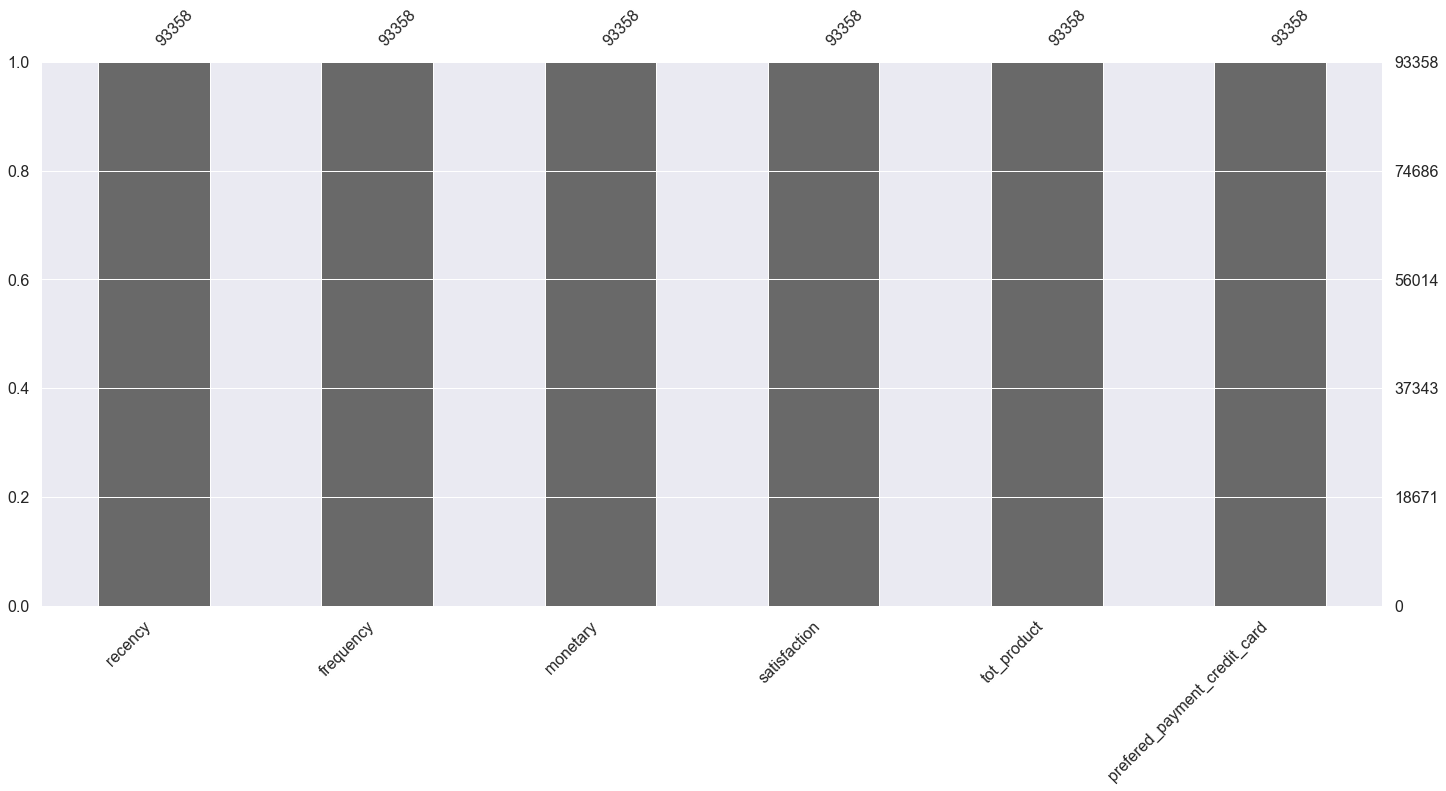

In [73]:
msno.bar(RFM_new)

array([[<AxesSubplot: title={'center': 'recency'}>,
        <AxesSubplot: title={'center': 'frequency'}>],
       [<AxesSubplot: title={'center': 'monetary'}>,
        <AxesSubplot: title={'center': 'satisfaction'}>],
       [<AxesSubplot: title={'center': 'tot_product'}>,
        <AxesSubplot: title={'center': 'prefered_payment_credit_card'}>]],
      dtype=object)

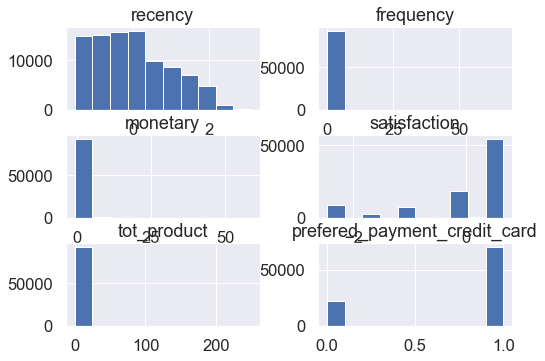

In [74]:
RFM_new.hist()

In [75]:
# Créer le DataFrame RFM_new en utilisant les données de df_new
RFM_new = pd.DataFrame()

# Appliquer np.log1p sur les colonnes "recency", "frequency" et "monetary" de df_new
RFM_new['recency'] = np.log1p(df_new['recency'])
RFM_new['frequency'] = np.log1p(df_new['frequency'])
RFM_new['monetary'] = np.log1p(df_new['monetary'])

# Appliquer np.log1p sur la colonne "review_score" pour "satisfaction"
RFM_new['satisfaction'] = np.log1p(df_new['review_score'])

# Appliquer np.log1p sur la colonne "tot_product"
RFM_new['tot_product'] = np.log1p(df_new['tot_product'])

# Séparer la colonne "prefered_payment_credit_card" sans transformation
prefered_payment_credit_card = X_scaled['prefered_payment_credit_card']

# Utilisation de MinMaxScaler pour normaliser les données
scaler = MinMaxScaler()
transformed_rfmNEW = scaler.fit_transform(RFM_new)

# Conversion en DataFrame avec les nouvelles valeurs normalisées
transformed_rfmNEW = pd.DataFrame(transformed_rfmNEW,
                                  columns=['recency', 'frequency', 'monetary', 'satisfaction', 'tot_product'])

# Ajouter la colonne "prefered_payment_credit_card" au DataFrame
transformed_rfmNEW['credit_card'] = prefered_payment_credit_card

# Afficher les premières lignes du nouveau jeu de données transformed_rfmNEW
display(transformed_rfmNEW.head())


recency  frequency  monetary  satisfaction  tot_product  credit_card
0  0.718092        0.0  0.512667      1.000000          0.0          1.0
1  0.722115        0.0  0.344968      0.834044          0.0          1.0
2  0.956644        0.0  0.461659      0.630930          0.0          1.0
3  0.878336        0.0  0.392412      0.834044          0.0          1.0
4  0.861826        0.0  0.546304      1.000000          0.0          1.0

array([[<AxesSubplot: title={'center': 'recency'}>,
        <AxesSubplot: title={'center': 'frequency'}>],
       [<AxesSubplot: title={'center': 'monetary'}>,
        <AxesSubplot: title={'center': 'satisfaction'}>],
       [<AxesSubplot: title={'center': 'tot_product'}>,
        <AxesSubplot: title={'center': 'credit_card'}>]], dtype=object)

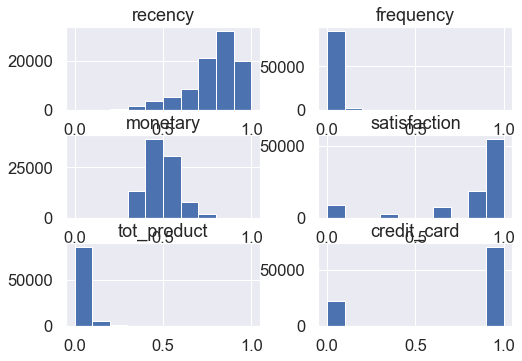

In [76]:
transformed_rfmNEW.hist()

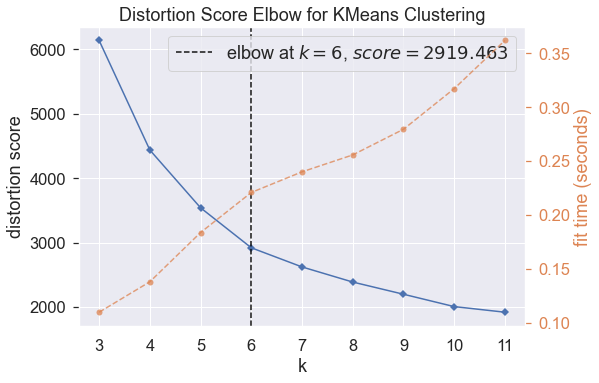

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [77]:
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model,
                              k=(3, 12))

visualizer.fit(transformed_rfmNEW)
visualizer.poof()

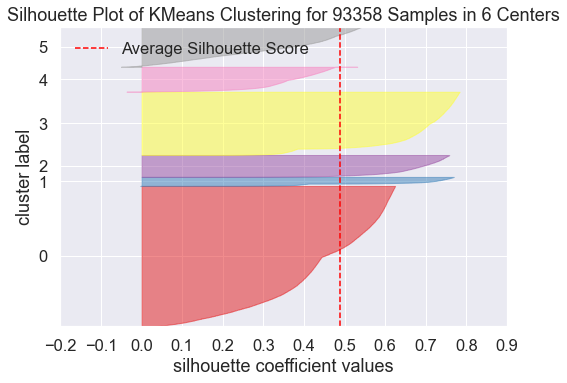

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [78]:
model = KMeans(6, n_init=10)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(transformed_rfmNEW)    
visualizer.poof() 

In [79]:
kmeans = KMeans(n_clusters = 6, random_state = 1, n_init=10)
kmeans.fit(transformed_rfmNEW)
# Extract cluster labels
cluster_labels = kmeans.labels_
        


In [80]:
# Créer un nouveau DataFrame RFM_with_Payment en extrayant les colonnes nécessaires de df_new
RFM_with_Payment = pd.DataFrame()

df_new = df_new.reset_index(drop=True)

# Extraire les colonnes "recency", "frequency" et "monetary" de df_new
RFM_with_Payment['recency'] = df_new['recency']
RFM_with_Payment['frequency'] = df_new['frequency']
RFM_with_Payment['monetary'] = df_new['monetary']

# Ajouter les colonnes "satisfaction", "tot_product" et "prefered_payment_credit_card" à partir de df_new
RFM_with_Payment['satisfaction'] = df_new['review_score']
RFM_with_Payment['tot_product'] = df_new['tot_product']
RFM_with_Payment['credit_card'] = X_scaled['prefered_payment_credit_card']

# Afficher les premières lignes du nouveau jeu de données RFM_with_Payment
display(RFM_with_Payment.head())


recency  frequency  monetary  satisfaction  tot_product  credit_card
0      111          1    141.90           5.0            1          1.0
1      114          1     27.19           4.0            1          1.0
2      536          1     86.22           3.0            1          1.0
3      320          1     43.62           4.0            1          1.0
4      287          1    196.89           5.0            1          1.0

In [81]:
RFM_with_Payment = RFM_with_Payment.assign(Cluster = cluster_labels)


clusters_RFM_new = RFM_with_Payment.groupby(['Cluster']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'satisfaction' : 'mean',
    'tot_product' : 'mean' ,
    'credit_card' : ['mean','count']
}).round(2)

display(clusters_RFM_new)

recency frequency monetary satisfaction tot_product credit_card       
           mean      mean     mean         mean        mean        mean  count
Cluster                                                                       
0         45.25      1.04   180.91         4.72        1.34         1.0  12483
1        242.02      1.04   151.35         4.57        2.21         0.0  19755
2        252.09      1.05   190.81         2.73        1.66         1.0   7787
3        287.19      1.03   173.25         4.74        1.32         1.0  43679
4        245.13      1.03   204.64         1.26        3.20         0.0   2818
5        230.64      1.01   235.13         1.00        1.81         1.0   6836

__Cluster 0: "Acheteurs Actifs et Satisfaits avec Carte de Crédit"__

Clients actifs et récents, satisfaits de leurs achats et utilisant des cartes de crédit pour le paiement.

__Cluster 1: "Acheteurs Inactifs sans Carte de Crédit"__

Clients moins actifs n'ayant pas effectué d'achats récents, dépensant modérément et n'utilisant pas de cartes de crédit.

__Cluster 2: "Acheteurs Occasionnels avec Carte de Crédit"__

Acheteurs moins actifs avec des dépenses modérées et utilisant des cartes de crédit pour le paiement.

__Cluster 3: "Acheteurs Fréquents et Satisfaits avec Carte de Crédit"__

Clients moins actifs, mais satisfaits de leurs achats et utilisant des cartes de crédit pour le paiement.

__Cluster 4: "Grands Dépensiers sans Carte de Crédit"__

Acheteurs moins actifs, mais dépensant davantage et n'utilisant pas de cartes de crédit.

__Cluster 5: "Acheteurs Occasionnels avec Dépenses Élevées et Carte de Crédit"__

Acheteurs moins actifs, mais avec des dépenses élevées et utilisant des cartes de crédit pour le paiement.

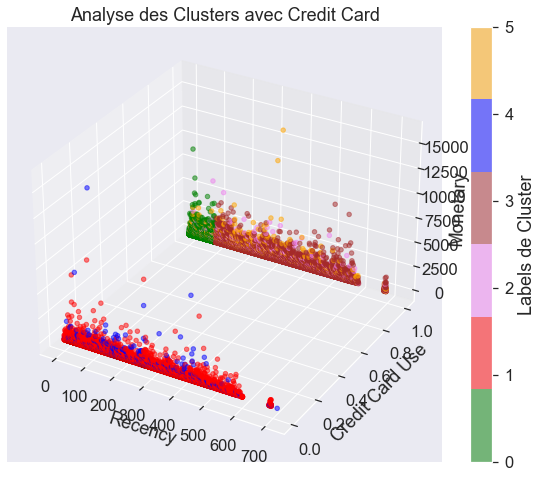

In [83]:
# Define a list of five unique colors
colors = ['green','red','violet','brown','blue','orange']

# Create a colormap with the specified colors
cmap = ListedColormap(colors)

# Create a 3D scatter plot with colors representing cluster labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the transformed RFM columns with cluster labels
scatter = ax.scatter(RFM_with_Payment.iloc[:, 0], RFM_with_Payment.iloc[:, 5], RFM_with_Payment.iloc[:, 2],
                     c=cluster_labels, cmap=cmap, alpha=0.5)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Labels de Cluster')

# Set labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Credit Card Use')
ax.set_zlabel('Monetary')
ax.set_title('Analyse des Clusters avec Credit Card')

# Show the plot
plt.show()

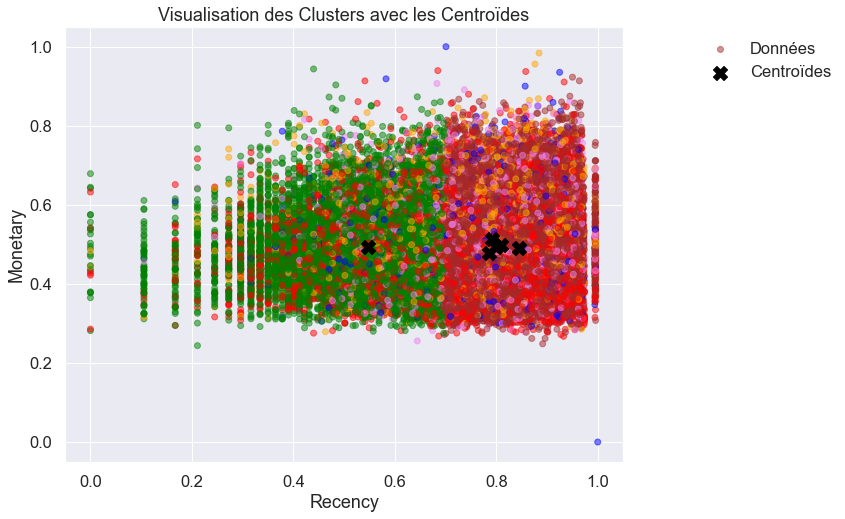

In [84]:
# Calcul des centroïdes pour chaque cluster
centroids = kmeans.cluster_centers_

# Création d'un graphique pour visualiser les centroïdes dans l'espace RFM
plt.figure(figsize=(10, 8))

# Tracer les points de données transformées
plt.scatter(transformed_rfmNEW['recency'], transformed_rfmNEW['monetary'], c=RFM_with_Payment['Cluster'],
            cmap=cmap, alpha=0.5)

# Tracer les centroïdes des clusters
plt.scatter(centroids[:, 0], centroids[:, 2], marker='X', color='black', s=200, label='Centroïdes')

# Ajout d'une barre de couleur et des étiquettes des axes

plt.xlabel('Recency')
plt.ylabel('Monetary')

# Déplacer la légende à l'extérieur du graphique
plt.legend(['Données', 'Centroïdes'], loc='upper right', bbox_to_anchor=(1.4, 1))

# Titre du graphique
plt.title('Visualisation des Clusters avec les Centroïdes')

# Affichage du graphique
plt.show()

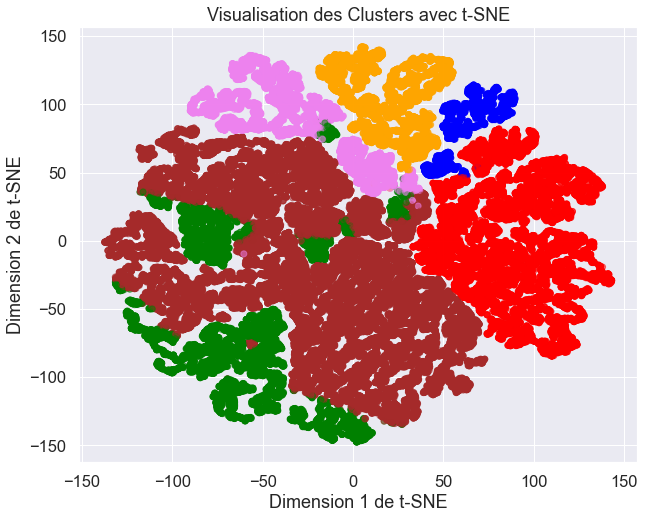

In [85]:
# Réaliser une réduction en 2 dimensions avec t-SNE sur le jeu de données transformed_rfmS
tsne = TSNE(n_components=2, random_state=1)
tsne_data = tsne.fit_transform(transformed_rfmNEW)

# Ajouter les résultats de t-SNE dans une nouvelle DataFrame
tsne_df = pd.DataFrame(data=tsne_data, columns=['tsne_1', 'tsne_2'])

# Obtenir les étiquettes de clusters à partir du modèle KMeans
cluster_labels = kmeans.labels_

# Créer un graphique de dispersion pour visualiser les points de données transformés avec t-SNE et leurs clusters
plt.figure(figsize=(10, 8))

# Tracer les points de données avec différentes couleurs représentant les différents clusters
# 'c=cluster_labels' permet de faire correspondre les étiquettes de clusters à des couleurs en utilisant la colormap (cmap) spécifiée
plt.scatter(tsne_df['tsne_1'], tsne_df['tsne_2'], c=cluster_labels, cmap=cmap, alpha=0.5)

# Ajouter les étiquettes des axes pour les dimensions t-SNE
plt.xlabel('Dimension 1 de t-SNE')
plt.ylabel('Dimension 2 de t-SNE')

# Ajouter un titre au graphique
plt.title('Visualisation des Clusters avec t-SNE')

# Afficher le graphique
plt.show()

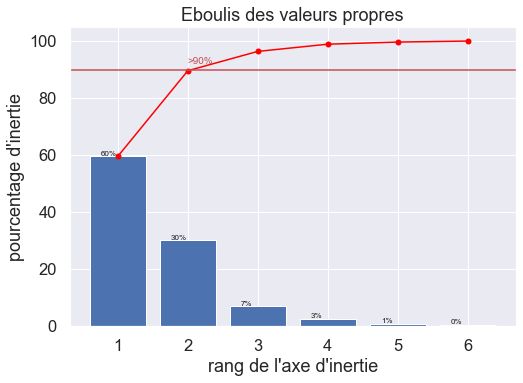

In [86]:
# Calculate principal components
n_comp = 6
pca = PCA(n_components=n_comp, random_state=1)
pca.fit(transformed_rfmNEW)

# Scree plot
display_scree_plot(pca)

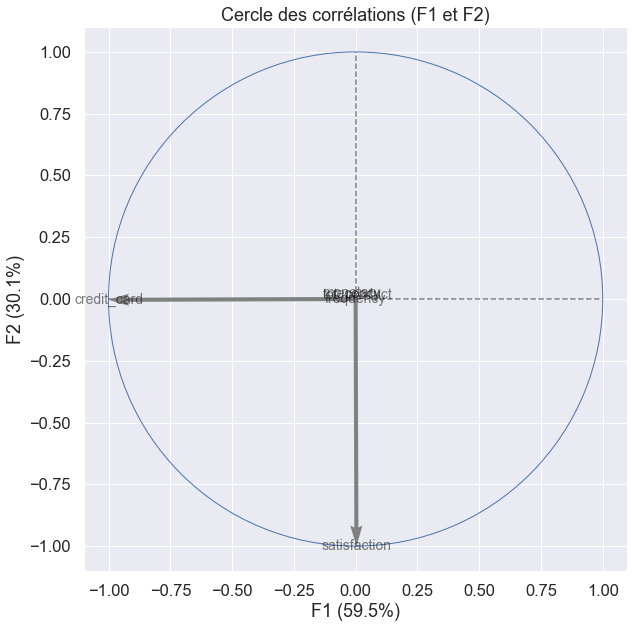

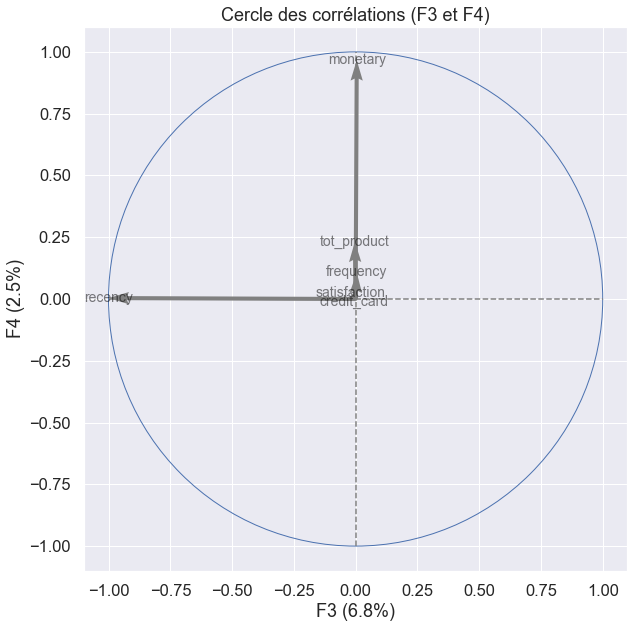

In [87]:
features = transformed_rfmNEW.columns
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0, 1),(2,3)], labels = np.array(features))

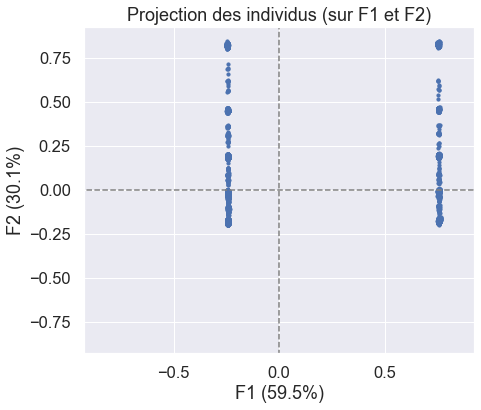

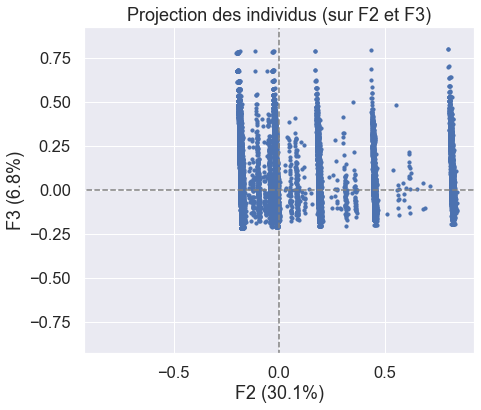

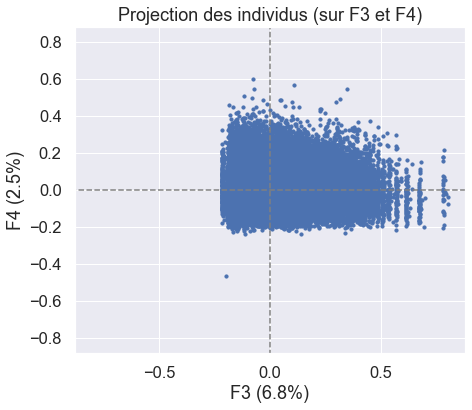

In [88]:
Trnfm_rfm = pca.transform(transformed_rfmNEW)
display_factorial_planes(Trnfm_rfm, n_comp, pca, [(0,1),(1,2),(2,3)])

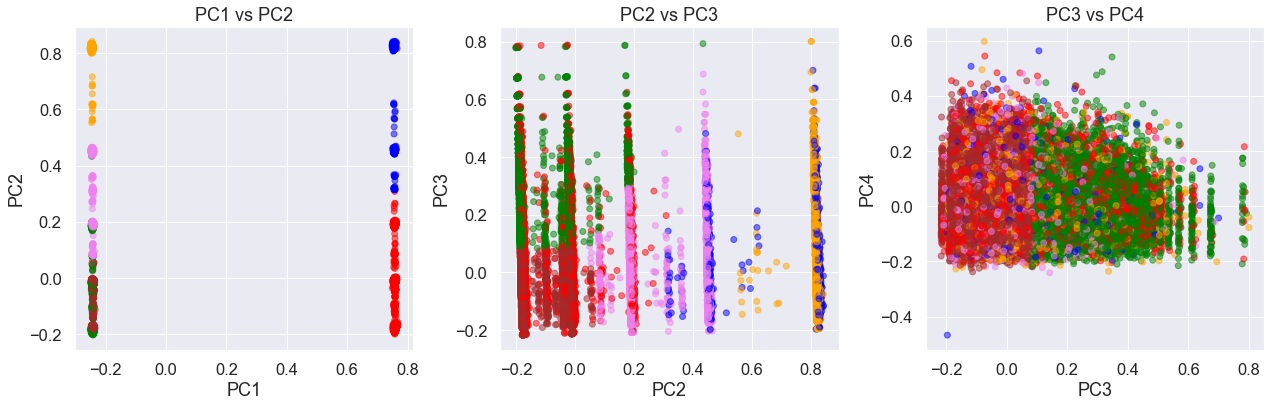

In [89]:
# Define the pairs of principal components to plot
pairs = [(0, 1), (1, 2), (2, 3)]

# Define the color code for cluster labels and the colormap for the scatter plot
colors = ['green', 'red', 'violet', 'brown', 'blue', 'orange']
cmap = ListedColormap(colors)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each pair of principal components
for i, pair in enumerate(pairs):
    # Scatter plot the scores of principal components with a color based on cluster labels
    axs[i].scatter(Trnfm_rfm[:, pair[0]], Trnfm_rfm[:, pair[1]], c=cluster_labels, cmap=cmap, alpha=0.5)
    axs[i].set_xlabel("PC{}".format(pair[0]+1))
    axs[i].set_ylabel("PC{}".format(pair[1]+1))
    axs[i].set_title("PC{} vs PC{}".format(pair[0]+1, pair[1]+1))

plt.tight_layout()
plt.show()


In [90]:
Trnfm_rfm

array([[-2.41996588e-01, -1.81768575e-01,  6.15247713e-02,
         1.70055733e-02, -1.79990206e-02, -1.54561137e-03],
       [-2.39701556e-01, -1.96266198e-02,  6.02740118e-02,
        -1.49310986e-01,  2.34607428e-02,  4.30062081e-04],
       [-2.41194947e-01,  1.91010390e-01, -1.69330385e-01,
        -4.09125807e-02, -8.64763670e-03,  3.03829476e-03],
       ...,
       [-2.40393027e-01, -1.77027473e-01, -1.85612017e-01,
        -5.10045203e-03, -1.24519466e-02, -6.45234212e-05],
       [-2.41848785e-01, -1.81709732e-01,  5.22730311e-02,
         1.11329627e-02, -1.64559957e-02, -1.47230472e-03],
       [-2.39734045e-01, -1.78593008e-01, -1.61474176e-01,
        -4.98215785e-02, -5.85092222e-04, -4.32105040e-05]])

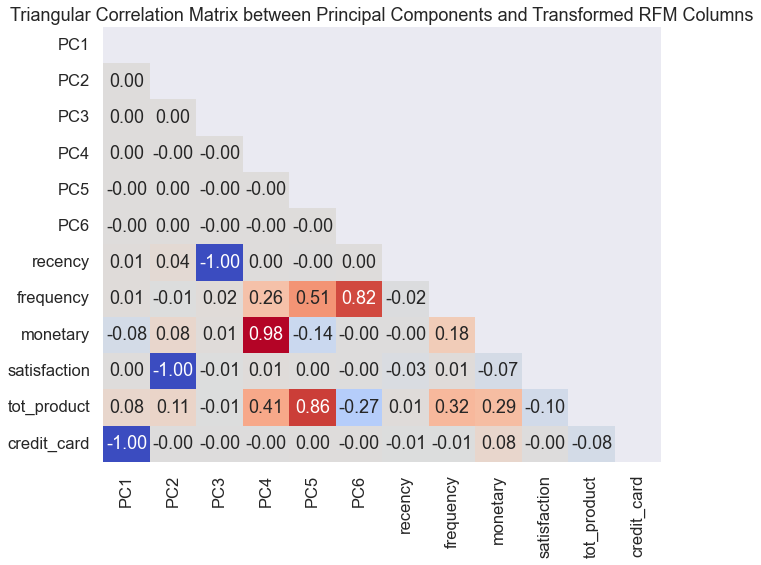

In [91]:
# Convert Trnfm_rfm to a DataFrame
Trnfm_rfm_df = pd.DataFrame(Trnfm_rfm, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

# Convert transformed_rfmNEW to a DataFrame
transformed_rfmNEW_df = pd.DataFrame(transformed_rfmNEW, columns=['recency', 'frequency', 'monetary', 'satisfaction', 'tot_product', 'credit_card'])

# Concatenate both DataFrames
merged_df = pd.concat([Trnfm_rfm_df, transformed_rfmNEW_df], axis=1)

# Compute the correlation matrix
correlation_matrix = merged_df.corr()

# Create a triangular correlation matrix without showing the lower triangle and diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask, cbar=False)
plt.title('Triangular Correlation Matrix between Principal Components and Transformed RFM Columns')
plt.show()


<a id='sec:conclusion'></a>
## VI. Conclusion

Dans le Notebook 2, nous avons exploré en détail la méthode RFM (Récence, Fréquence, Montant) et avons appliqué différentes techniques de Machine Learning pour segmenter les clients d'Olist. Grâce à cette analyse, nous avons pu diviser la base de clients en groupes distincts en fonction de leur comportement d'achat, ce qui nous a permis de mieux comprendre leurs préférences et leurs besoins.

Cependant, il est essentiel de garder à l'esprit que les comportements des clients évoluent au fil du temps en fonction de divers facteurs, tels que les tendances du marché, les changements économiques ou les campagnes promotionnelles. Par conséquent, la segmentation des clients doit être régulièrement mise à jour pour rester pertinente et utile dans la prise de décisions marketing.